#Compra e venda de veículos usados
O objetivo deste projeto é usar a base de dados de um marketplace de compra e venda para entender o mercado nacional de compra e venda de veículos usados para determinar os preços pelos quais serão vendidos os carros do cliente.

É um problema de regressão, para o qual decidiremos o melhor modelo dentre as opções:
* Regressão Linear
* Floresta aleatória
* KNN
* Redes neurais

A métrica utilizada será a MAE(Mean Absolut Error, ou Erro Absoluto Médio).

(Uma análise mais detalhada e a argumentação para a escolha das métricas e modelos ocorrerá ao longo do arquivo.)

Este trabalho foi desenvolvido por [Claudia Cavalcante Fonseca](https://purrfect.codes).

In [2]:
# Importando as bibliotecas para análise de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

#Lendo o arquivo csv
df_train = pd.read_csv("lighthouse_cars_train.csv", encoding='utf-16', delimiter='\t')
df_test= pd.read_csv('lighthouse_cars_test.csv', encoding='utf-16', delimiter='\t')


## Limpando e preenchendo campos

In [4]:
print("Valores únicos:")
print(pd.DataFrame({'Trein. Unicos': df_train.nunique(),
                    'Trein. Nulos': df_train.isnull().sum(),
                    'Teste Unicos': df_test.nunique().apply(lambda x: f'%.0f' % x),
                    'Teste Nulos': df_test.isnull().sum().apply(lambda x: f'%.0f' % x)
                    }).sort_values(by='Trein. Unicos', ascending=False))
#display(df_train.info())

Valores únicos:
                         Trein. Unicos  Trein. Nulos Teste Unicos Teste Nulos
preco                            29584             0          NaN         NaN
id                               29584             0         9862           0
hodometro                        26004             0         9430           0
versao                            1916             0         1377           0
cidade_vendedor                    575             0          337           0
modelo                             457             0          378           0
marca                               40             0           39           0
ano_de_fabricacao                   35             0           34           0
estado_vendedor                     25             0           24           0
ano_modelo                          17             0           17           0
num_fotos                           14           177           13          60
tipo                                 7          

Percepções:
* Verificamos que não há veículos alienados nos nossos dados. Isso significa que a coluna `veiculo_alienado` não nos será útil, já que todos os registros estão na mesma condição. O mesmo ocorre com a coluna `elegivel_revisao`: Como todos os carros estão elegíveis para revisão, essa coluna não nos traz informação alguma.
* As colunas relativas a valores booleanos (ou seja, valores "sim" ou "não") estão todas com 1 valor de registro e vários resultados nulos. Verificando os valores na tabela, vemos que quando estão preenchidas significa que o valor é "sim" e quando não estão o valor é "não".
* Além desses valores, outra coluna com registros com valores nulos é a `num_fotos`. Vamos precisar verificar se há algum registro com "0" fotos. Se não houver, provavelmente registros com essa coluna nula representam veículos sem fotos nos anúncios.
* A coluna `id` é um identificador e também não será útil para análises.

Decisões:
* Remover as colunas `veiculo_alienado`, `elegivel_revisao` e `id`.
* Alterar os valores das colunas `veiculo_único_dono`, `veiculo_licenciado`, `elegivel_revisao`, `revisoes_dentro_agenda`, `revisoes_concessionaria`, `dono_aceita_troca`, `garantia_de_fábrica`, `ipva_pago` para "0" caso estejam nulas e "1" caso estejam preenchidas.
* Verificar se há registros com "0" fotos. Caso não haja, alterar os registros com uma quantidade de fotos nula para "0" fotos. Caso haja, criaremos uma categoria nova para os registros sem essa informação.

In [5]:
# Removendo as colunas "veiculo_alienado" e "elegivel_revisao":
df_test_final = pd.DataFrame()
df_test_final['id']=df_test['id']
df_train.drop(["veiculo_alienado", "elegivel_revisao",'id'], axis=1,inplace=True)
df_test.drop(["veiculo_alienado", "elegivel_revisao",'id'], axis=1,inplace=True)

# Alterando os valores das colunas com um só valor único:
colunas_bool = ["veiculo_único_dono", "veiculo_licenciado", "revisoes_dentro_agenda", "revisoes_concessionaria",
                "dono_aceita_troca", "garantia_de_fábrica", "ipva_pago"]
for coluna in colunas_bool:
    df_train[coluna] = (~df_train[coluna].isna()).astype(int)
    df_test[coluna] = (~df_test[coluna].isna()).astype(int)
# Verificando os valores iguais a "0" da coluna num_fotos:
display((df_train["num_fotos"] == 0).value_counts())

False    29584
Name: num_fotos, dtype: int64

In [6]:
# Assim, vamos alterar os nulos de "num_fotos", colocando-os como "0"
df_train['num_fotos'].fillna(0,inplace=True)
df_test['num_fotos'].fillna(0,inplace=True)

#Seguindo com a análise do banco, vamos imprimir os tipos de valores das colunas e a (nova) quantidade de nulos.
print(pd.concat([df_train.dtypes.rename('Trein.'),df_test.dtypes.rename('Teste')], axis=1))


                          Trein.    Teste
num_fotos                float64  float64
marca                     object   object
modelo                    object   object
versao                    object   object
ano_de_fabricacao          int64    int64
ano_modelo               float64  float64
hodometro                float64  float64
cambio                    object   object
num_portas                 int64    int64
tipo                      object   object
blindado                  object   object
cor                       object   object
tipo_vendedor             object   object
cidade_vendedor           object   object
estado_vendedor           object   object
anunciante                object   object
entrega_delivery            bool     bool
troca                       bool     bool
dono_aceita_troca          int64    int64
veiculo_único_dono         int64    int64
revisoes_concessionaria    int64    int64
ipva_pago                  int64    int64
veiculo_licenciado         int64  

Agora classificaremos as colunas conforme seu tipo, porque vamos tratá-las de forma diferente.



* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
tipo


Sedã                    16429
Hatchback                4924
Picape                   4849
Utilitário esportivo     3322
Perua/SW                   27
Cupê                       26
Minivan                     7
Name: tipo, dtype: int64

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
cor


Branco      20949
Preto        5256
Prata        1741
Cinza        1634
Dourado         2
Verde           1
Vermelho        1
Name: cor, dtype: int64

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
cambio


Automática               22545
Manual                    4989
CVT                       1792
Automatizada               139
Automatizada DCT            53
Semi-automática             41
Automática Sequencial       25
Name: cambio, dtype: int64

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
anunciante


Pessoa Física                       17999
Loja                                 9879
Concessionária                       1702
Acessórios e serviços para autos        4
Name: anunciante, dtype: int64

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
num_portas


4    28697
2      868
3       19
Name: num_portas, dtype: int64

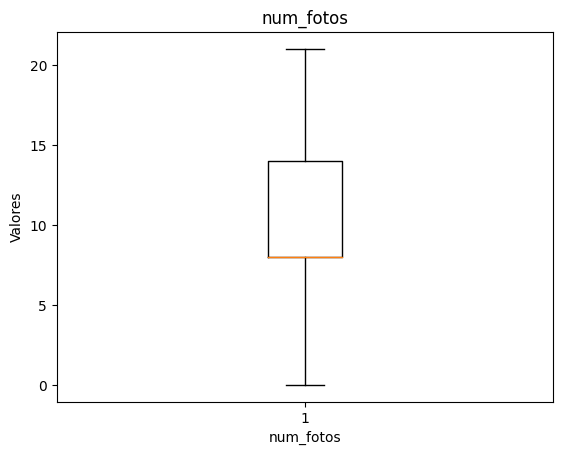

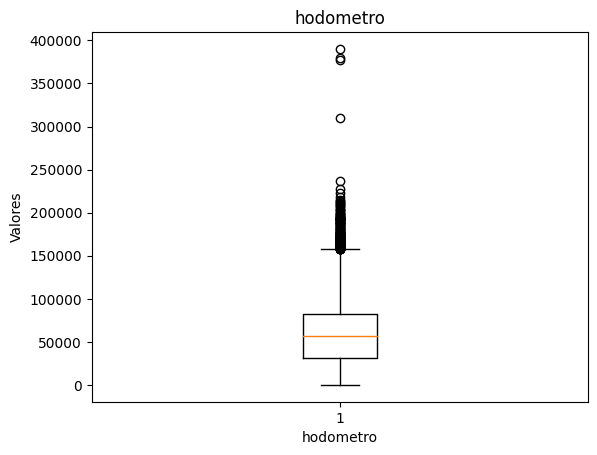

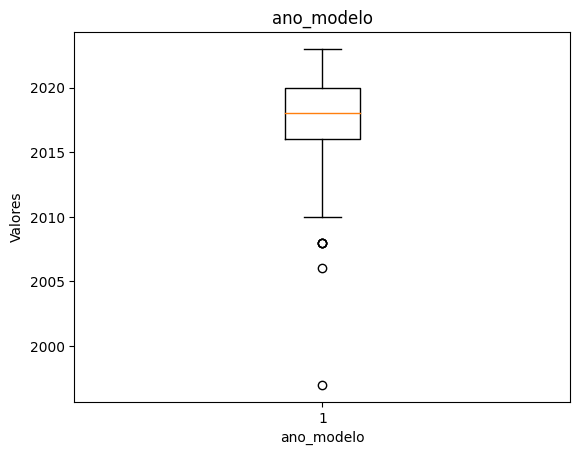

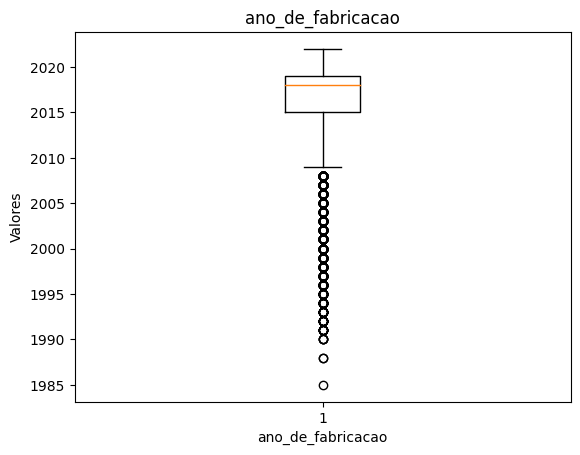

In [24]:
numericas=['preco','hodometro','ano_de_fabricacao', 'ano_modelo', 'num_fotos']
categoricas_mtosvalores=['versao', 'cidade_vendedor', 'estado_vendedor', 'modelo','marca']
categoricas=['tipo','cor','cambio', 'anunciante', 'num_portas']
booleanas=['blindado', 'entrega_delivery', 'troca', 'tipo_vendedor', 'veiculo_único_dono',
          'veiculo_licenciado', 'revisoes_dentro_agenda', 'revisoes_concessionaria',
          'dono_aceita_troca', 'garantia_de_fábrica', 'ipva_pago']

#Vamos analisar a quantidade de dados com cada valor em cada feature
for column in categoricas:
  print("* "*32,column, sep='\n')
  display(df_train[column].value_counts())

for column in list(set(numericas) - set(['preco'])):
  plt.boxplot(df_train[column])
  plt.xlabel(column)
  plt.ylabel('Valores')
  plt.title(column)
  plt.show()

Analisando os boxplots, percebi que os anos de modelo e de fabricação não batem. Especificamente, há registros com um ano de fabricação muito inferior ao ano do modelo.

Vamos analisar esse problema mais a fundo.

In [8]:
df_filtered = df_train[(df_train['ano_modelo']-df_train['ano_de_fabricacao'] > 2)].sort_values('ano_de_fabricacao')
display(df_filtered[['ano_modelo','ano_de_fabricacao','marca','modelo','versao','num_portas']].head(20))
print(len(df_filtered))

,ano_modelo,ano_de_fabricacao,marca,modelo,versao,num_portas
590,2013.0,1985,VOLKSWAGEN,GOL,1.6 MI POWER 8V FLEX 4P MANUAL G.III,4
19658,2011.0,1988,VOLKSWAGEN,FUSCA,1.6 8V GASOLINA 2P MANUAL,4
13276,2011.0,1988,PEUGEOT,307,2.0 GRIFFE 16V GASOLINA 4P AUTOMÁTICO,4
1156,2013.0,1990,FIAT,PALIO,1.3 MPI FIRE ELX WEEKEND 8V FLEX 4P MANUAL,4
2032,2010.0,1990,VOLKSWAGEN,GOL,1.6 MI POWER 8V FLEX 4P MANUAL G.IV,4
20366,2012.0,1990,LAND ROVER,DISCOVERY 3,2.7 HSE 4X4 V6 24V TURBO DIESEL 4P AUTOMÁTICO,4
18397,2013.0,1990,FORD,RANGER,2.8 XLT LIMITED 4X4 CD 8V TURBO INTERCOOLER DI...,4
17584,2012.0,1991,HYUNDAI,AZERA,3.3 MPFI GLS SEDAN V6 24V GASOLINA 4P AUTOMÁTICO,4
20958,2013.0,1991,HYUNDAI,SANTA FÉ,2.7 MPFI GLS 7 LUGARES V6 24V GASOLINA 4P AUTO...,4
4960,2013.0,1991,FORD,RANGER,2.8 XLT LIMITED 4X4 CD 8V TURBO INTERCOOLER DI...,2


1521


É natural que o ano de fabricação seja maior que o ano do lançamento modelo ou que seja um pouco inferior (1 ou 2 anos), no caso do carro ser fabricado nas primeiras linhas de montagem, ainda antes do lançamento do modelo. Mas, há registros cujo ano de fabricação é de 1985 e ano do modelo é de 2013.

Não conseguimos analisar todos os registros um a um, porque há carros com muitos anos de lançamento de modelo, já que há vários modelos.  Porém, conseguimos alguns exemplos de carros cujo ano de lançamento do modelo está claramente equivocado.

Por exemplo:
* O Peugeot 307 foi lançado apenas de 2001 a 2014 segundo a [Wikipédia](https://en.wikipedia.org/wiki/Peugeot_307). Assim, seria impossível que ele tivesse sido fabricado em 1988.

* Também segundo a [Wikipédia](https://pt.wikipedia.org/wiki/Fiat_Palio) o Fiat Palio foi lançado pela Fiat entre 1996 e 2018. Assim, seria impossível que ele tivesse sido fabricado em 1990.

* Da mesma forma, a [Wikipédia](https://en.wikipedia.org/wiki/Land_Rover_Discovery) também nos informa que modelos de Land Rover Discovery 3 foram lançados de 2004 a 2009. Assim, seria impossível que ele tivesse sido fabricado em 1990 (Neste caso, também seria impossível que seu modelo fosse de 2012).

Esse padrão se repete ao longo da tabela. Infelizmente, não temos como conferir os anos de fabricação de todos os registros ou mesmo os anos de lançamento dos modelos.

Fica claro, porém, que há inconsistências nessas colunas. Muito provavelmente por erro humano ao cadastrar os carros para venda. Neste caso, nossas opções são:
* Ignorar esses erros e tratar os dados como relevantes
* Ignorar as colunas, considerando-as dados não confiáveis
* Ignorar apenas a coluna `ano_de_fabricacao`, que possui as maiores inconsistências
* Ignorar esses 1521 registros em que constatamos as inconsistências com absoluta certeza

Mas, ainda não sabemos nem o impacto que essas colunas terão sobre a predição do preço. Assim, vamos mantê-las por enquanto.


Outra coluna interessante é a coluna `versao`, que apresenta detalhes sobre o automóvel que podem ser relevantes para a determinação do preço de venda. Essa coluna, porém, é uma junção de diversas características importantes do veículo. Para fazer jus a essa heterogeneidade do campo versão, vamos separar a coluna em algumas outras colunas, que identifiquem cada característica escondida nesse campo. Vamos analisar como fazer isso.

In [9]:
pd.set_option('display.max_colwidth', 100)
display(df_train['versao'].head(20))

0                                    1.6 16V FLEXSTART SL 4P XTRONIC
1                                    2.0 16V FLEX LIMITED AUTOMÁTICO
2                              2.4 16V GASOLINA EX 7L AWD AUTOMÁTICO
3     2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIESEL 4P AUTOMÁTICO
4                         2.0 GLS 4X4 16V TURBO DIESEL 4P AUTOMÁTICO
5                                1.0 COMFORT PLUS 12V FLEX 4P MANUAL
6                                          2.0 16V FLEXONE EX 4P CVT
7                                      1.5 LX 16V FLEX 4P AUTOMÁTICO
8                                 1.0 TSI HIGH UP 12V FLEX 4P MANUAL
9                       2.7 SRV 7 LUGARES 4X2 16V FLEX 4P AUTOMÁTICO
10                                   1.8 SE-G 16V FLEX 4P AUTOMÁTICO
11                                        2.0 4X4 16V FLEX 4P MANUAL
12                    2.0 TFSI AMBIENTE QUATTRO 4P GASOLINA S TRONIC
13                                   2.0 16V FLEX LIMITED AUTOMÁTICO
14                    2.0 TFSI AMB

A versão do câmbio (CVT, automático ou manual) e a quantidade de portas (2P, 4P) já é descrita em outra coluna. Assim, essa informação está redundante.

Porém, há outras características que podem ser relevantes para a precificação do veículo, como cilindradas (1.0, 2.0, 2.7, 1.4, ...) , sistema de tração (4x4 ou 4x2) e tipo de combustível(Diesel, Flex, Gasolina, etc).

Vamos criar novas colunas para essas características, eliminar a coluna `versao` e, futuramente, verificar a viabilidade de utilização dessas colunas (visto que pode haver poucos registros com elas preenchidas).






In [10]:
combustiveis_orig=['FLEX','DIESEL','GASOLINA','HÍBRIDO','ELÉTRICO','ELECTRIC']
combustiveis_cod=['flex','diesel','gasolina','hibrido','eletrico','eletrico']
conditions_train = [df_train['versao'].str.contains(combustivel, case=False) for combustivel in combustiveis_orig]
conditions_test = [df_test['versao'].str.contains(combustivel, case=False) for combustivel in combustiveis_orig]

df_train['combustivel']=np.select(conditions_train, combustiveis_cod, default='não identificado')
df_test['combustivel']=np.select(conditions_test, combustiveis_cod, default='não identificado')

df_train['tracao']=np.select([df_train['versao'].str.contains('4X4', case=False)], [1], default=0)
df_test['tracao']=np.select([df_test['versao'].str.contains('4X4', case=False)], [1], default=0)

df_train['cilindradas'] = df_train['versao'].str.slice(0, 3)
df_test['cilindradas'] = df_test['versao'].str.slice(0, 3)

df_train['cilindradas'] = pd.to_numeric(df_train['cilindradas'], errors='coerce')
df_train.loc[df_train['cilindradas'] == 90.0, 'cilindradas'] = np.nan
df_train.loc[df_train['cilindradas'] == 0.6, 'cilindradas'] = np.nan

df_train.loc[df_train['cilindradas'].isna(), 'combustivel'] = 'eletrico'

df_test['cilindradas'] = pd.to_numeric(df_test['cilindradas'], errors='coerce')
df_test.loc[df_test['cilindradas'] == 90.0, 'cilindradas'] = np.nan

print("Treino")
display(pd.crosstab(index=df_train['cilindradas'], columns='Contagem').T)
display("Nulas:",df_train['cilindradas'].isna().sum())
display(df_train['combustivel'].value_counts())
print("Teste")
display(pd.crosstab(index=df_test['cilindradas'], columns='Contagem').T)
display("Nulas:",df_test['cilindradas'].isna().sum())
display(df_test['combustivel'].value_counts())

numericas.append('cilindradas')
categoricas.append('combustivel')
booleanas.append('tracao')

Treino


cilindradas,1.0,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,...,4.7,4.8,4.9,5.0,5.2,5.5,5.7,5.9,6.2,6.7
col_0,,,,,,,,,,,,,,,,,,,,,
Contagem,3300,28,220,2706,1419,4280,16,2307,2,10340,...,5,20,3,64,2,19,9,1,41,164


'Nulas:'

77

flex                16209
gasolina             7749
diesel               4472
não identificado      949
hibrido               128
eletrico               77
Name: combustivel, dtype: int64

Teste


cilindradas,0.6,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,...,4.7,4.8,5.0,5.2,5.5,5.7,5.9,6.2,6.3,6.7
col_0,,,,,,,,,,,,,,,,,,,,,
Contagem,1,1150,1,4,66,901,464,1363,3,768,...,3,4,34,3,10,4,2,17,1,51


'Nulas:'

23

flex                5416
gasolina            2607
diesel              1440
não identificado     343
hibrido               33
eletrico              23
Name: combustivel, dtype: int64

Criar esses campos novos acabou criando um problema extra. Carros elétricos não têm cilindradas e, embora eles sejam uma parte pequena da nossa amostra, são relevantes, visto que seu valor costuma ser superior.

Vamos precisar estudar uma forma de preencher essas cilindradas de uma forma que não prejudique os dados já obtidos.
As opções que temos são:
* Considerar o campo numérico `cilindradas` como um campo categórico. Nesse caso, nosso prejuízo seria quanto à ordenação das cilindradas. Nós perderíamos a informação de que um carro com 2.0 cilindradas tem mais cilindradas do que um 1.0, por exemplo. E isso pode ser prejudicial em algum sentido.
* Preencher o campo `cilindradas` dos carros elétricos. Essa opção pode representar um problema quando esse campo for preenchido com valores que não contribuam para a precificação do carro e é possível que causem ruído no modelo. Nosso plano será usar a média das cilindradas dos carros com preços mais próximos e prever algo semelhante às cilindradas. Depois, povoaremos as cilindradas do dataset de teste com a média das cilindradas (que acabamos de prever) dos registros de mesma marca/modelo do dataset de treino. Pretendemos com isso reduzir o ruído desses dados fictícios no dataset real, sem, no entanto, perder a informação das cilindradas dos carros não-elétricos, que são a maior parte dos nossos dados.

In [11]:
#display(df_train[df_train['cilindradas'].isna()][['marca', 'modelo','versao']].value_counts())
#display(df_test[df_test['cilindradas'].isna()][['marca', 'modelo','versao']].value_counts())
# Verificamos que os modelos dos carros elétricos são os mesmos no teste e no treino.
# Vamos tentar estimar algo semelhante às cilindradas deles com base nos carros de preço semelhante.
# E como não temos o preço dos carros no dataset de teste,
#   vamos usar a média das cilindradas do dataset treino dos carros com o exato mesmo modelo.
def calcular_cilindradas(preco):
  df_train['diff'] = abs(df_train['preco'] - preco)
  df_train_sorted = df_train[df_train['cilindradas'].notna()].sort_values(by='diff')
  ar_cilindradas = sorted(df_train_sorted.head(10)['cilindradas'])[2:-2]
  df_train.drop(["diff"], axis=1,inplace=True)
  return (round(pd.Series(ar_cilindradas).mean(),1));

df_train.loc[df_train['cilindradas'].isna(), 'cilindradas'] = df_train[df_train['cilindradas'].isna()]['preco'].apply(calcular_cilindradas)
display("Nulas:",df_train['cilindradas'].isna().sum())


'Nulas:'

0

In [12]:
# Agora já que já preenchemos os campos "cilindradas" no df_train,
# vamos prever esses valores para o df_test.
marca_modelos_unicos = df_test[df_test['cilindradas'].isna()][['marca', 'modelo','versao']].value_counts().index.to_list()
display(marca_modelos_unicos)

for i in marca_modelos_unicos:
  print("===============\n",i[0],i[1])
  media = round(df_train[(df_train['marca']==i[0]) & (df_train['modelo']==i[1]) & (df_train['versao']==i[2])]['cilindradas'].mean(),1)
  df_test.loc[(df_test['marca'] == i[0]) & (df_test['modelo'] == i[1]) & (df_test['versao'] == i[2]) & (df_test['cilindradas'].isna()), 'cilindradas'] = media
  display(df_test[(df_test['marca']==i[0]) & (df_test['modelo']==i[1]) & (df_test['versao']==i[2])]['cilindradas'])



[('NISSAN', 'LEAF', 'B12P 40 ELÉTRICO'),
 ('CHEVROLET', 'BOLT', 'EV 60 ELÉTRICO'),
 ('PORSCHE', 'TAYCAN', '4S ELÉTRICO'),
 ('AUDI', 'E-TRON', 'ELÉTRICO SPORTBACK PERFORMANCE BLACK QUATTRO'),
 ('BMW', 'i3', 'BEV 8V ELÉTRICO 4P AUTOMÁTICO'),
 ('BMW', 'i3', 'ELÉTRICO eDRIVE BEV AUTOMÁTICO'),
 ('JAGUAR', 'I-PACE', '90 KW EV400 SE AWD ELÉTRICO')]

 NISSAN LEAF


375     2.2
1417    2.2
2704    2.2
3229    2.2
4002    2.2
4400    2.2
5298    2.2
8339    2.2
8729    2.2
9317    2.2
9516    2.2
9525    2.2
9527    2.2
9669    2.2
Name: cilindradas, dtype: float64

 CHEVROLET BOLT


794     2.3
2938    2.3
9601    2.3
Name: cilindradas, dtype: float64

 PORSCHE TAYCAN


1676    2.9
9658    2.9
Name: cilindradas, dtype: float64

 AUDI E-TRON


7117    2.0
Name: cilindradas, dtype: float64

 BMW i3


2497    1.6
Name: cilindradas, dtype: float64

 BMW i3


2521    2.2
Name: cilindradas, dtype: float64

 JAGUAR I-PACE


532    2.3
Name: cilindradas, dtype: float64

Agora o campo cilindradas está preenchido nos carros elétricos com uma média das cilindradas dos carros com o preço mais próximo no dataset de treino. E os campos do dataset de teste estão com as cilindradas dos mesmos modelos (marca,modelo,versão) do dataset de treino.

In [13]:
#E, finalmente, vamos apagar a coluna "versao"
df_train.drop(['versao'], axis=1,inplace=True)
df_test.drop(['versao'], axis=1,inplace=True)
categoricas_mtosvalores.remove('versao')

In [14]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_fotos                29584 non-null  float64
 1   marca                    29584 non-null  object 
 2   modelo                   29584 non-null  object 
 3   ano_de_fabricacao        29584 non-null  int64  
 4   ano_modelo               29584 non-null  float64
 5   hodometro                29584 non-null  float64
 6   cambio                   29584 non-null  object 
 7   num_portas               29584 non-null  int64  
 8   tipo                     29584 non-null  object 
 9   blindado                 29584 non-null  object 
 10  cor                      29584 non-null  object 
 11  tipo_vendedor            29584 non-null  object 
 12  cidade_vendedor          29584 non-null  object 
 13  estado_vendedor          29584 non-null  object 
 14  anunciante            

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9862 entries, 0 to 9861
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_fotos                9862 non-null   float64
 1   marca                    9862 non-null   object 
 2   modelo                   9862 non-null   object 
 3   ano_de_fabricacao        9862 non-null   int64  
 4   ano_modelo               9862 non-null   float64
 5   hodometro                9862 non-null   float64
 6   cambio                   9862 non-null   object 
 7   num_portas               9862 non-null   int64  
 8   tipo                     9862 non-null   object 
 9   blindado                 9862 non-null   object 
 10  cor                      9862 non-null   object 
 11  tipo_vendedor            9862 non-null   object 
 12  cidade_vendedor          9862 non-null   object 
 13  estado_vendedor          9862 non-null   object 
 14  anunciante              

None

# Estatística Descritiva

Já fizemos algumas observações enquanto limpávamos os dados. Vamos apenas repassar todas as estatísticas que descrevem nossos dados e verificar a coluna nova de cilindradas.

,num_fotos,ano_de_fabricacao,ano_modelo,hodometro,num_portas,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,preco,tracao,cilindradas
count,29584.000000,29584.000000,29584.000000,29584.000000,29584.000000,29584.000000,29584.000000,29584.000000,29584.000000,29584.000000,29584.000000,29584.000000,2.958400e+04,29584.000000,29584.000000
mean,10.262067,2016.758552,2017.808985,58430.592077,3.940677,0.741009,0.352319,0.310032,0.664515,0.537655,0.147546,0.199770,1.330239e+05,0.133417,1.927616
std,3.566878,4.062422,2.673930,32561.769309,0.338360,0.438088,0.477701,0.462514,0.472168,0.498588,0.354655,0.399834,8.166287e+04,0.340030,0.741465
min,0.000000,1985.000000,1997.000000,100.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.869951e+03,0.000000,1.000000
25%,8.000000,2015.000000,2016.000000,31214.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.657177e+04,0.000000,1.500000
50%,8.000000,2018.000000,2018.000000,57434.000000,4.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.143558e+05,0.000000,2.000000
75%,14.000000,2019.000000,2020.000000,81953.500000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.636796e+05,0.000000,2.000000
max,21.000000,2022.000000,2023.000000,390065.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.359813e+06,1.000000,6.700000



 tipo


count     29584
unique        7
top        Sedã
freq      16429
Name: tipo, dtype: object

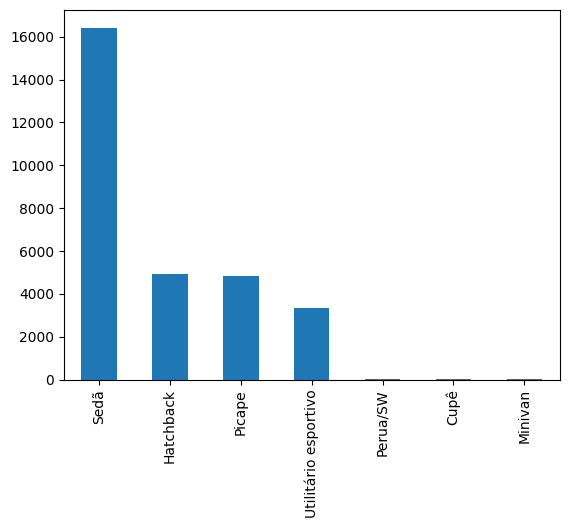


 cor


count      29584
unique         7
top       Branco
freq       20949
Name: cor, dtype: object

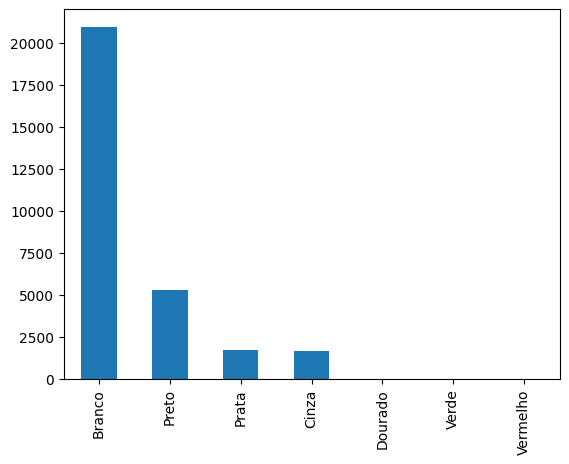


 cambio


count          29584
unique             7
top       Automática
freq           22545
Name: cambio, dtype: object

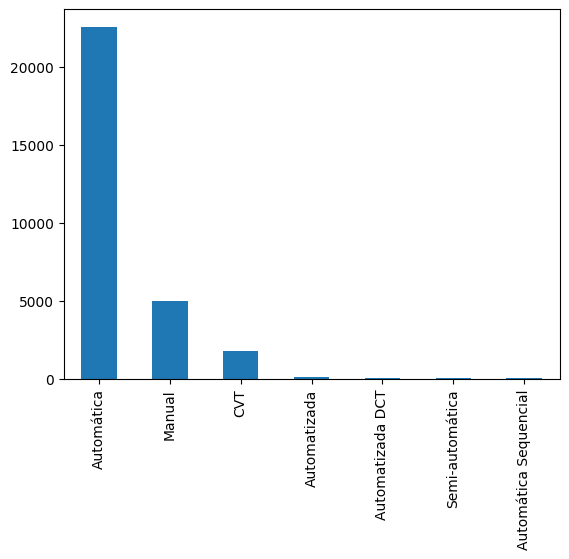


 anunciante


count             29584
unique                4
top       Pessoa Física
freq              17999
Name: anunciante, dtype: object

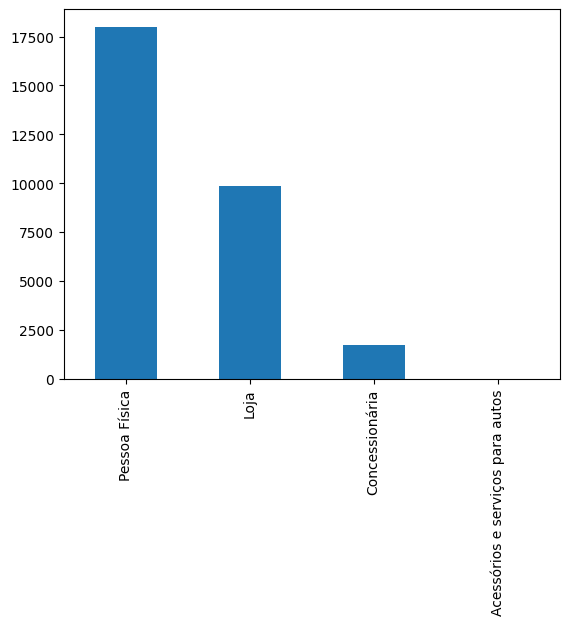


 num_portas


count    29584.000000
mean         3.940677
std          0.338360
min          2.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          4.000000
Name: num_portas, dtype: float64

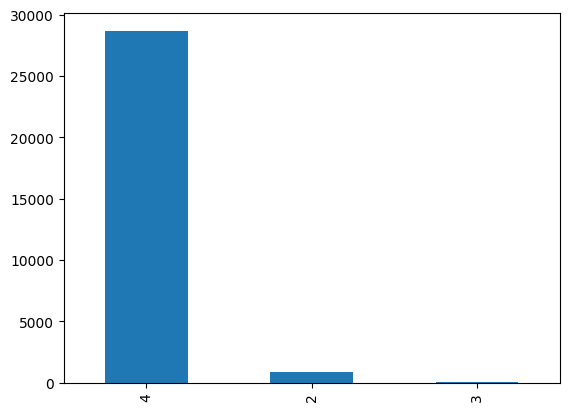


 combustivel


count     29584
unique        6
top        flex
freq      16209
Name: combustivel, dtype: object

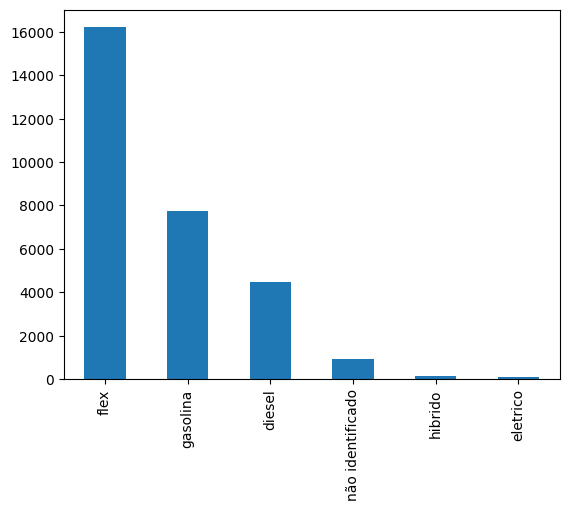


 cidade_vendedor


count         29584
unique          575
top       São Paulo
freq           6158
Name: cidade_vendedor, dtype: object


 estado_vendedor


count              29584
unique                25
top       São Paulo (SP)
freq               16378
Name: estado_vendedor, dtype: object


 modelo


count       29584
unique        457
top       COMPASS
freq         1480
Name: modelo, dtype: object


 marca


count          29584
unique            40
top       VOLKSWAGEN
freq            4594
Name: marca, dtype: object

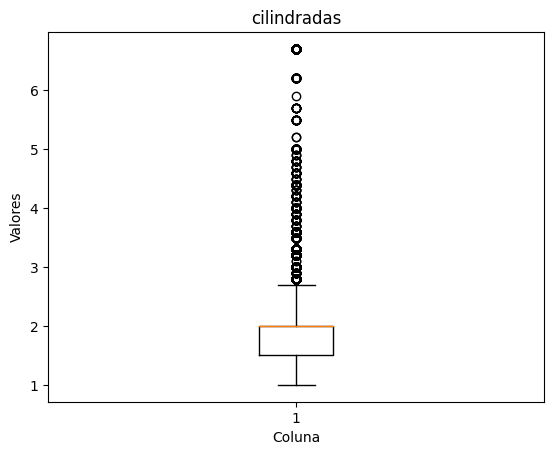

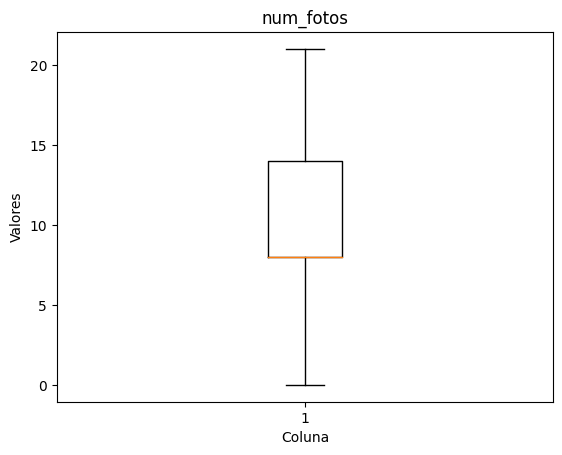

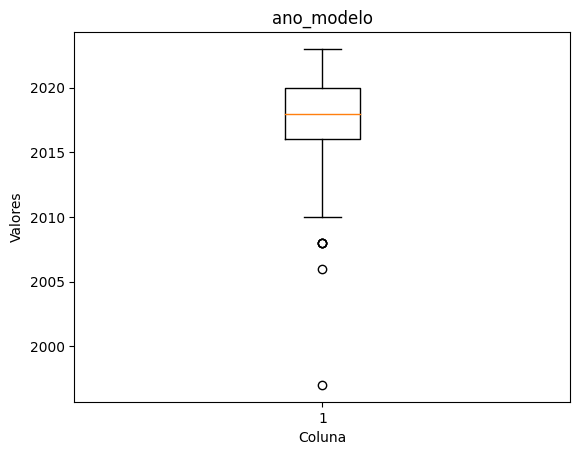

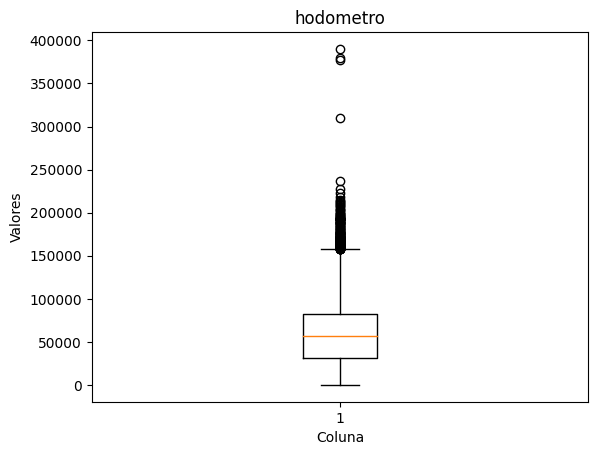

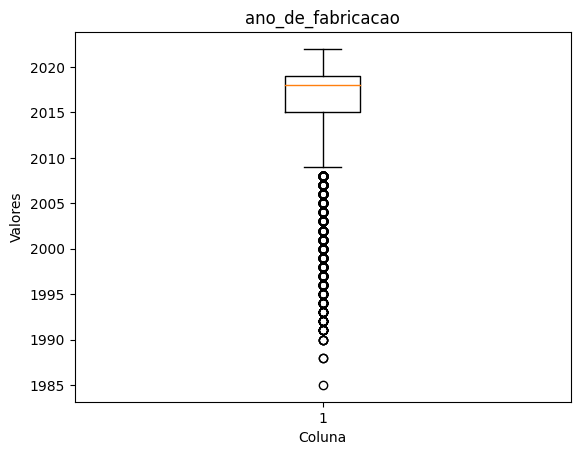

In [22]:
display(df_train.describe())
for i in categoricas+categoricas_mtosvalores:
  print('\n',i)
  display(df_train[i].describe())
  if i in categoricas:
    df_train[i].value_counts().plot(kind='bar')
    plt.show()

for column in list(set(numericas) - set(['preco'])):
  plt.boxplot(df_train[column])
  plt.xlabel(i)
  plt.ylabel('Valores')
  plt.title(column)
  plt.show()


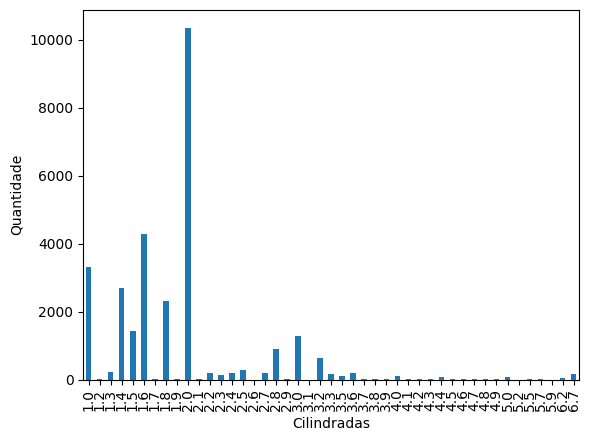

In [26]:
df_train['cilindradas'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Cilindradas')
plt.ylabel('Quantidade')
plt.show()

A quantidade de carros com mais de 2 cilindradas e diferente de `3.0`, `2.8` e `2.2` é muito pequena, o que pode ajudar a explicar a flutuação de preços nessa categoria mais à frente na análise exploratória.

Isso também significa que nosso modelo pode ser pior pra prever o preço de veículos com essas cilindradas.

# Análise Exploratória de Dados

Hipóteses:
* Carros com mais cilindradas tendem a ter preços maiores.
* Carros elétricos tendem a ter preços maiores.
* Carros mais velhos tendem a ter um maior valor no hodometro e preços menores.

## Analisando relações entre a coluna `preço` e as demais

['preco', 'hodometro', 'ano_modelo', 'cilindradas']


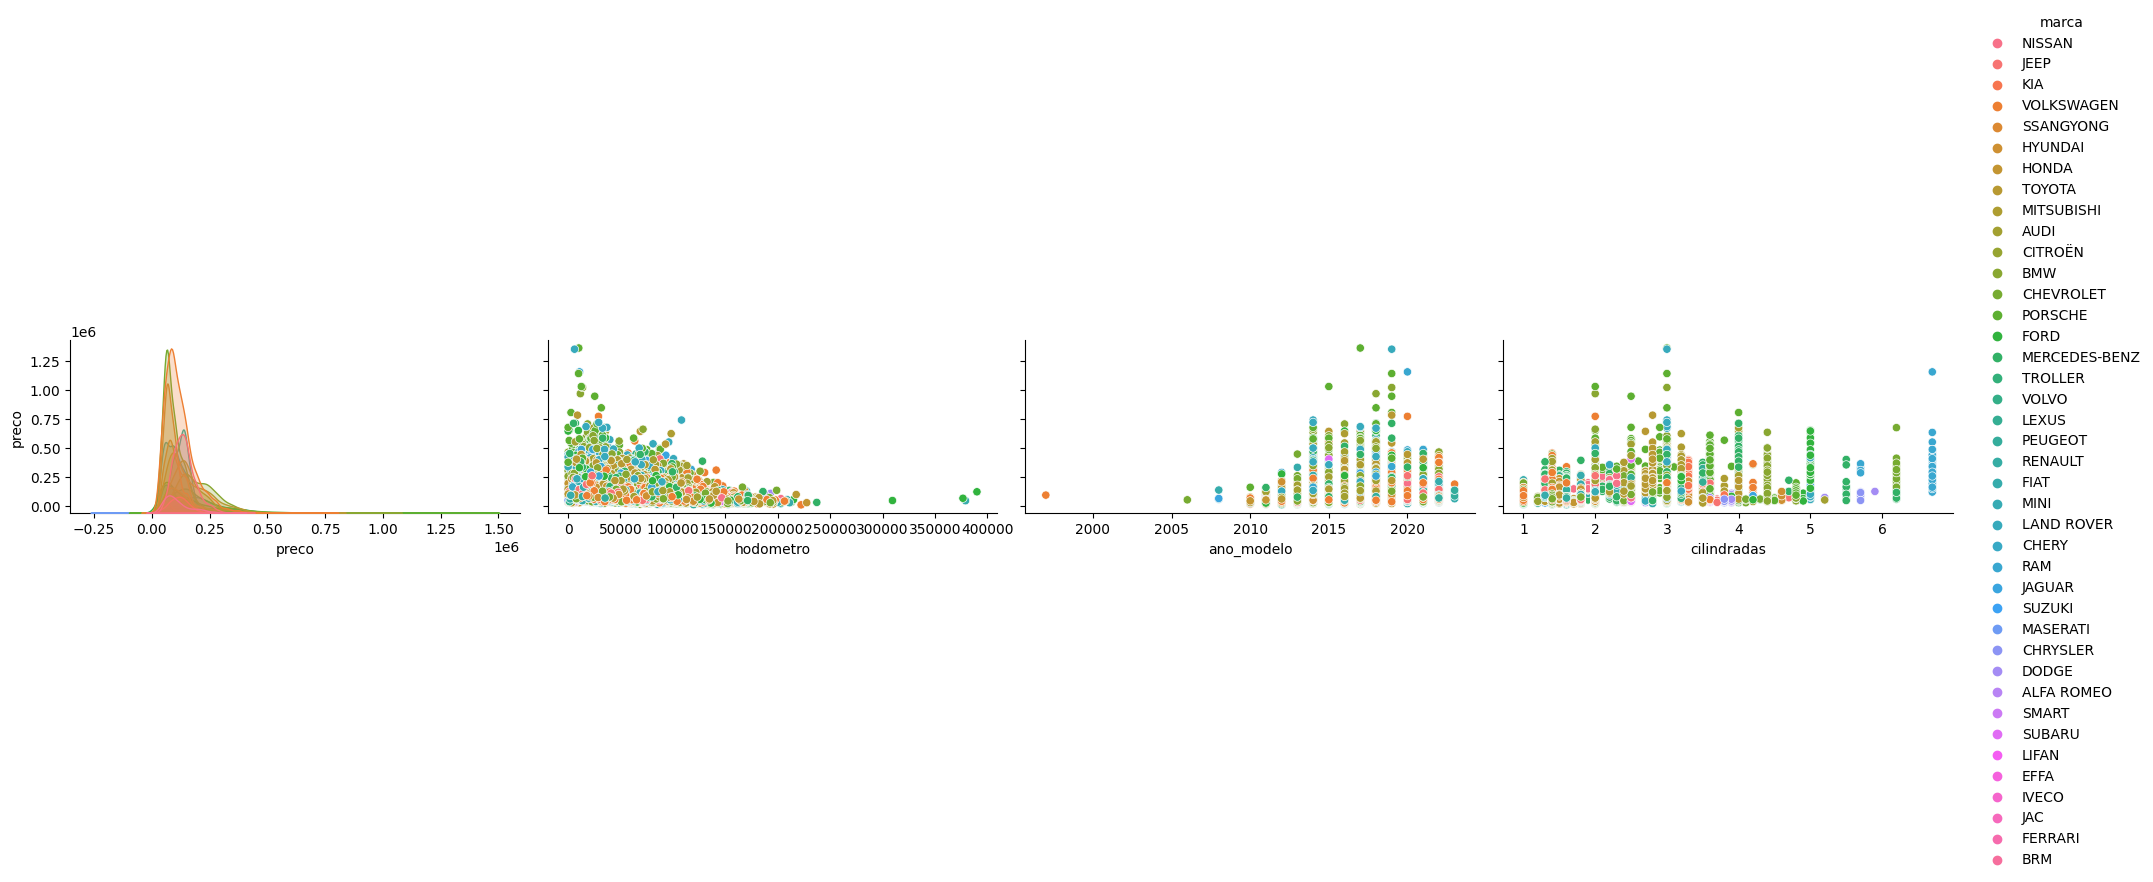

['tipo', 'cor', 'cambio', 'anunciante', 'num_portas', 'combustivel']
tipo


Sedã                    16429
Hatchback                4924
Picape                   4849
Utilitário esportivo     3322
Perua/SW                   27
Cupê                       26
Minivan                     7
Name: tipo, dtype: int64

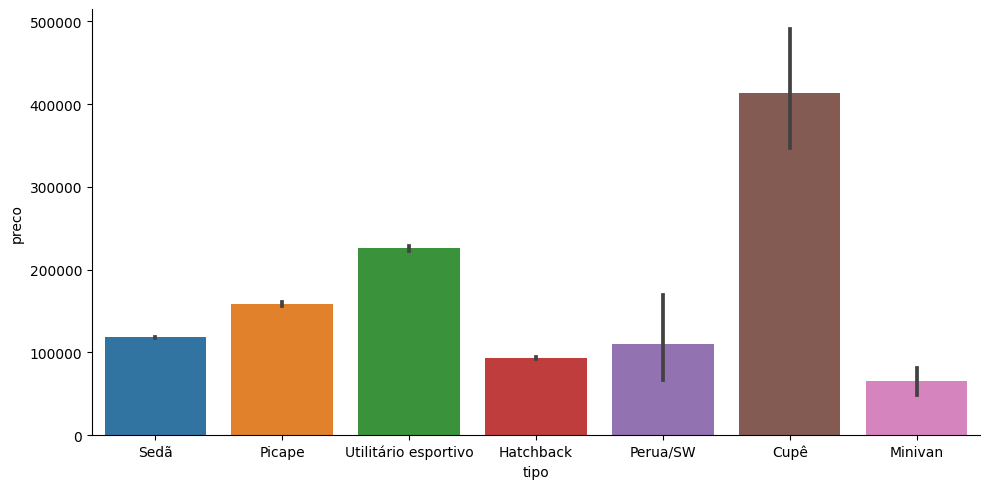

cor


Branco      20949
Preto        5256
Prata        1741
Cinza        1634
Dourado         2
Verde           1
Vermelho        1
Name: cor, dtype: int64

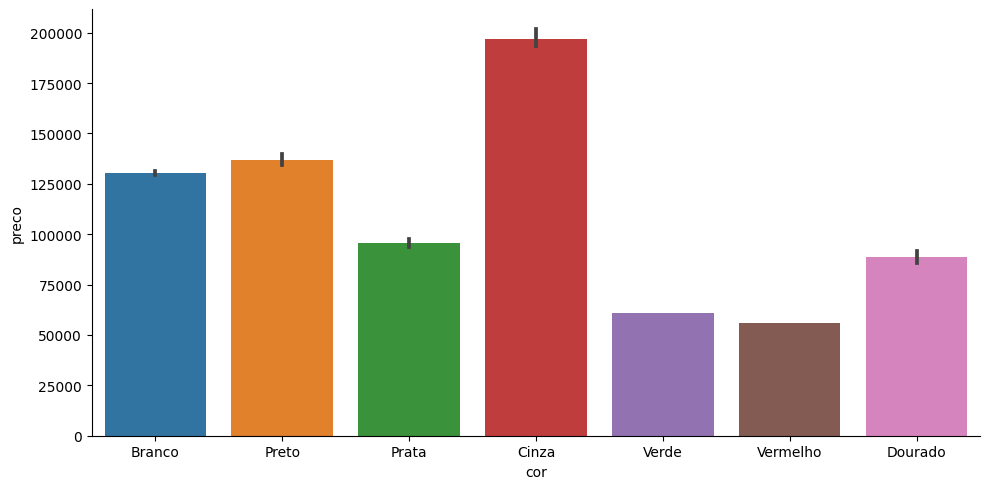

cambio


Automática               22545
Manual                    4989
CVT                       1792
Automatizada               139
Automatizada DCT            53
Semi-automática             41
Automática Sequencial       25
Name: cambio, dtype: int64

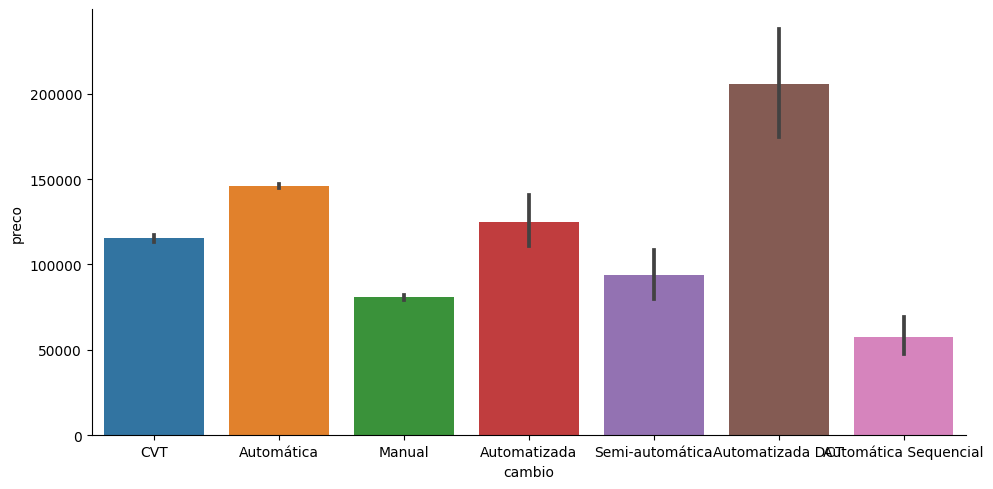

anunciante


Pessoa Física                       17999
Loja                                 9879
Concessionária                       1702
Acessórios e serviços para autos        4
Name: anunciante, dtype: int64

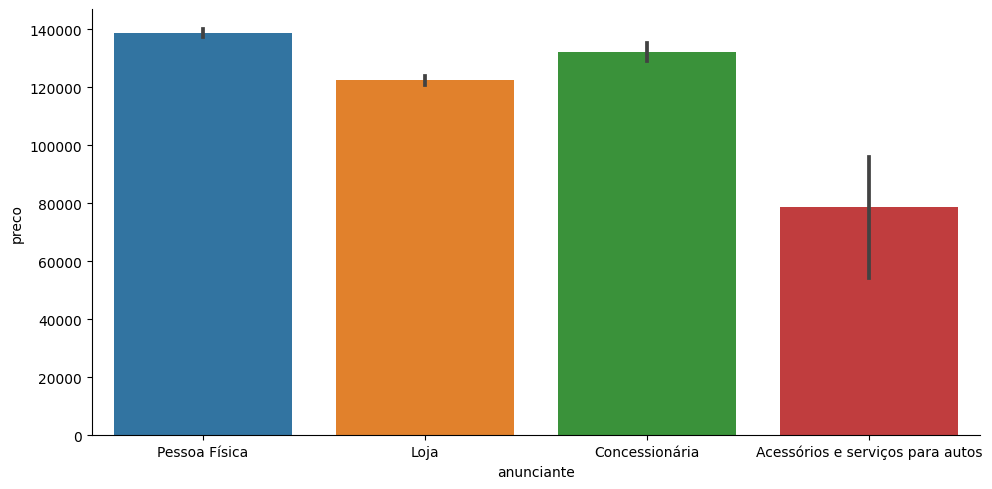

num_portas


4    28697
2      868
3       19
Name: num_portas, dtype: int64

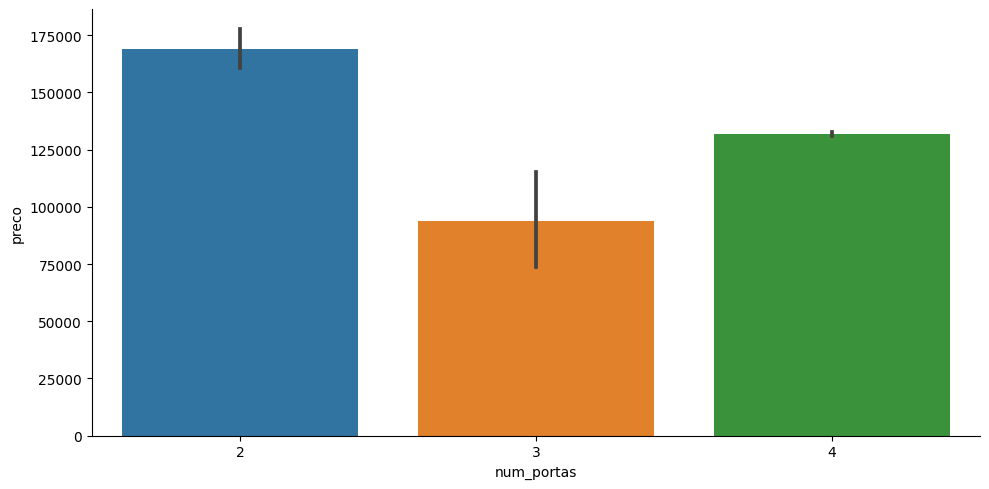

combustivel


flex                16209
gasolina             7749
diesel               4472
não identificado      949
hibrido               128
eletrico               77
Name: combustivel, dtype: int64

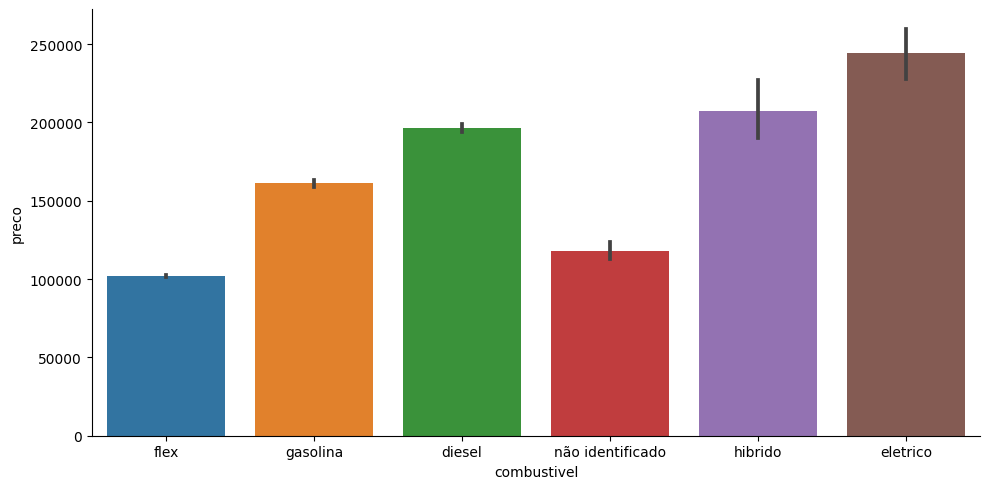

cidade_vendedor


,Coluna,Quantidade,Média de preço,Desvio padrão
165,Muzambinho,2,36313.0000,17281.0000
174,Guarujá,2,41260.0000,22610.0000
181,Marituba,2,46471.0000,20035.0000
157,Pomerode,2,48298.0000,36456.0000
141,Fartura,3,50563.0000,21183.0000
...,...,...,...,...
175,Nhandeara,2,291653.0000,159212.0000
100,Balneário Camboriú,7,297950.0000,103707.0000
122,Parauapebas,4,301285.0000,159949.0000
121,Presidente Alves,4,423074.0000,189948.0000


estado_vendedor


,Coluna,Quantidade,Média de preço,Desvio padrão
14,Amazonas (AM),51,85051.0000,34982.0000
17,Acre (AC),29,93107.0000,51962.0000
10,Paraíba (PB),108,94476.0000,33659.0000
19,Espírito Santo (ES),21,96534.0000,34117.0000
13,Ceará (CE),69,102756.0000,49326.0000
15,Mato Grosso do Sul (MS),35,113270.0000,63783.0000
11,Rio Grande do Norte (RN),90,115937.0000,58464.0000
8,Pernambuco (PE),318,117126.0000,62762.0000
20,Tocantins (TO),20,119591.0000,51097.0000
12,Pará (PA),74,121009.0000,42651.0000


modelo


,Coluna,Quantidade,Média de preço,Desvio padrão
193,SIENA,5,30906.0000,12830.0000
131,207,17,34745.0000,16038.0000
153,307,12,38830.0000,24819.0000
222,GRAND BLAZER,2,39254.0000,15179.0000
206,CORSA,3,41188.0000,19488.0000
...,...,...,...,...
87,RANGE ROVER VELAR,45,367811.0000,170989.0000
145,M2,13,385138.0000,216257.0000
112,911,25,411129.0000,265044.0000
149,RS6,12,413860.0000,139199.0000


marca


,Coluna,Quantidade,Média de preço,Desvio padrão
29,CHRYSLER,30,62570.0000,24651.0000
19,CITROËN,194,73494.0000,42942.0000
28,DODGE,37,74371.0000,25802.0000
14,RENAULT,538,82649.0000,39558.0000
32,LIFAN,8,84162.0000,31537.0000
3,HYUNDAI,2043,84420.0000,34554.0000
30,SSANGYONG,14,84982.0000,47250.0000
31,SMART,12,91243.0000,46812.0000
26,SUZUKI,41,92605.0000,40170.0000
1,CHEVROLET,3020,93188.0000,48756.0000


In [ ]:
from matplotlib.ticker import ScalarFormatter

# Colunas numericas
print(numericas)
sns.pairplot(df_train[numericas+['marca']], y_vars=['preco'], aspect=2, hue='marca')
plt.show()

# Colunas categoricas
print(categoricas)
for categoria in categoricas:
  print(categoria)
  display(df_train[categoria].value_counts())
  df_catplot = df_train[[categoria,'preco']]
  sns.catplot(data=df_catplot, x=categoria, y='preco', kind='bar', estimator=np.mean, aspect=2)
  plt.show()

for categoria in categoricas_mtosvalores:
  tabela = pd.DataFrame(columns=['Coluna','Quantidade','Média de preço','Desvio padrão'])
  print(categoria)
  contagem = df_train[categoria].value_counts()
  for valor, contagem_valor in contagem.items():
    df_filtered = df_train[df_train[categoria] == valor]
    media_preco, desvio_padrao= df_filtered['preco'].mean(), df_filtered['preco'].std()
    if (desvio_padrao/media_preco > 0.3):#contagem_valor>200:
      nova_linha = pd.DataFrame([[valor, contagem_valor, media_preco.round(),desvio_padrao.round()]], columns=['Coluna', 'Quantidade', 'Média de preço','Desvio padrão'])
      tabela = pd.concat([tabela, nova_linha], ignore_index=True)
  display(tabela.sort_values(by='Média de preço'))


#print(categoricas_mtosvalores)
#print(booleanas)

In [ ]:
print('Analisando as observações quanto à cor Prata:')
a=df_train[df_train['cor']=='Prata']['tipo'].value_counts()
b=df_train['tipo'].value_counts()
print(a/b)
print('A porcentagem original de carros de cada tipo:')
c=len(df_train.index)
print(b/c)

Analisando as observações quanto à cor Prata:
Cupê                      NaN
Hatchback              0.0918
Minivan                   NaN
Perua/SW               0.1852
Picape                 0.0229
Sedã                   0.0712
Utilitário esportivo   0.0009
Name: tipo, dtype: float64
A porcentagem original de carros de cada tipo:
Sedã                   0.5553
Hatchback              0.1664
Picape                 0.1639
Utilitário esportivo   0.1123
Perua/SW               0.0009
Cupê                   0.0009
Minivan                0.0002
Name: tipo, dtype: float64


In [ ]:
#Analisando as observações quanto à quantidade de cilindradas:

a=df_train[df_train['combustivel']=='flex']['tipo'].value_counts()
b=df_train['tipo'].value_counts()
print(a/b)

Cupê                      NaN
Hatchback              0.6495
Minivan                0.8571
Perua/SW               0.2222
Picape                 0.3788
Sedã                   0.6425
Utilitário esportivo   0.1827
Name: tipo, dtype: float64


In [ ]:
#Analisando o tipo de carros com mais de 4 cilindradas
df_train[df_train['cilindradas']>4]['tipo'].value_counts()

Picape                  206
Sedã                    164
Utilitário esportivo     53
Hatchback                31
Cupê                      7
Perua/SW                  2
Name: tipo, dtype: int64

Como já era de se esperar:
* Quanto maior a quilometragem do carro no hodometro, menor tende a ser o preço do carro.
* Modelos mais novos de carros (quanto ao ano de fabricação ou do modelo), em geral, são mais caros.
* A quantidade de fotos no anúncio aparentemente não infuencia tão diretamente no preço do carro, apesar de termos muitos carros com 15 fotos.
* O tipo do carro influencia bastante no preço pelo qual ele foi vendido. Hatchbacks, peruas e minivans são normalmente mais baratos do que esportivos ou cupês.
* Carros de câmbio automático ou automatizado são mais caros do que carros com câmbio manual ou Automática Sequencial.

Resultados não esperados:
* Numa primeira vista, a quantidade de cilindradas do motor também parece não ser tão intimamente ligada ao preço do carro. Porém, talvez o baixo preço de carros com mais de 4 cilindradas se deva ao fato de que há apenas 7 carros do tipo Cupê nesse grupo.
* Normalmente se acredita que carros brancos valem menos (mesmo porque seu preço, quando comprado novo, é menor). Mas, nosso banco de dados não confirma essa crença, mostrando que carros prata ou coloridos (verde, vermelho, dourado) são mais baratos. Quanto aos coloridos, provavelmente isso está ligado ao fato de que há apenas 4 carros coloridos no banco e, portanto, não há dados suficientes para tirarmos uma conclusão. Quanto aos carros prata, verificamos que essa condição provavelmente se dá devido às quantidades percentuais de carros prata dentro de cada tipo de carro. Por exemplo, 18% das peruas são prata, enquanto apenas 9% são Hatchback, 7% são sedã e 2% são picapes.
* Carros com 3 ou 4 portas tendem a ser mais baratos. Essa afirmação não parece fazer muito sentido, mas veremos a seguir que todos os 19 registros com 3 portas são picapes e quase todos os registros com 2 portas também. Assim, mesmo com menos portas, seu preço tende a se superior devido ao tipo do carro (picapes são o terceiro tipo de carro com maior preço).
* Carros elétricos têm um maior preço. Seguidos pelo híbrido, diesel e gasolina. A surpresa neste caso fica por conta dos carros flex, que podem receber gasolina ou diesel, mas, segundo nosso banco, possuem um preço menor que os demais. Porém, analisando os tipos de carros que são flex, vemos que a grande maioria das Minivans e Hatchbacks são flex, quando nenhum Cupê e apenas 18% dos esportivos têm esse tipo de combustível.

In [ ]:
#Convertendo colunas booleanas para os valores em {0,1}
#df_train[booleanas].info()
df_train['blindado'] = df_train['blindado'].map({'S': 1, 'N': 0})
df_train['pessoa_fisica'] = df_train['tipo_vendedor'].map({'PF': 1, 'PJ': 0})
df_train['entrega_delivery'] = df_train['entrega_delivery'].map({True: 1, False: 0})
df_train['troca'] = df_train['troca'].map({True: 1, False: 0})
df_train.drop('tipo_vendedor', axis=1,inplace=True)
booleanas.remove('tipo_vendedor')
booleanas.append('pessoa_fisica')
df_train[booleanas].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   blindado                 29584 non-null  int64
 1   entrega_delivery         29584 non-null  int64
 2   troca                    29584 non-null  int64
 3   veiculo_único_dono       29584 non-null  int64
 4   veiculo_licenciado       29584 non-null  int64
 5   revisoes_dentro_agenda   29584 non-null  int64
 6   revisoes_concessionaria  29584 non-null  int64
 7   dono_aceita_troca        29584 non-null  int64
 8   garantia_de_fábrica      29584 non-null  int64
 9   ipva_pago                29584 non-null  int64
 10  tracao                   29584 non-null  int64
 11  pessoa_fisica            29584 non-null  int64
dtypes: int64(12)
memory usage: 2.7 MB


## Analisando relações entre duas ou mais colunas

<function matplotlib.pyplot.show(close=None, block=None)>

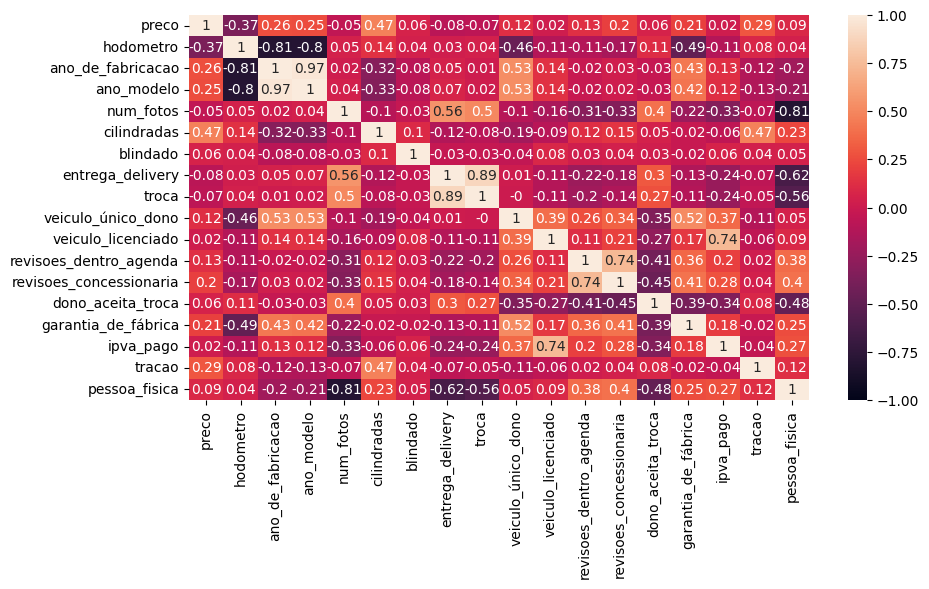

In [ ]:
from scipy import stats

plt.figure(figsize=(10,5))
sns.heatmap(df_train[numericas+booleanas].corr(method='spearman').round(2), vmin=-1, vmax=1, annot=True);
plt.show

Percepções:
* As colunas `ano_modelo` e `ano_de_fabricacao` têm correlação muito alta (`0.97`), apesar de já termos observados que existem alguns casos com alguma inconsistência nos dados (especialmente no que diz respeito ao `ano_de_fabricacao`). Além disso, ao comprar um carro usado, dificilmente nos importamos mais com o ano de fabricação do que com o ano do modelo, que inclusive aparece frequentemente nos títulos dos anúncios.
* Ambas também possuem uma correlação negativa muito grande (`-0.8` e `-0.81`) com o hodometro (quanto mais velho o carro, mais ele rodou).
* As colunas `entrega_delivery` e `troca` também têm grande correlação.


Muito provavelmente será mais benéfico retirar algumas colunas do nosso modelo, pra reduzir a multicolinearidade e ajudar a evitar sobreajuste e instabilidade nas estimativas dos coeficientes do modelo.

Vamos analisar a multicolinearidade de cada uma das nossas variáveis.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
df = df_train[numericas+booleanas]
X = df.drop(['preco'], axis=1)

# Adicione uma constante ao conjunto de dados (opcional, dependendo do modelo que será utilizado)
X = sm.add_constant(X)

# Calculando o VIF para cada variável independente
vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.options.display.float_format = '{:.4f}'.format

print(vif)

                   Variável          VIF
0                     const 2188779.3774
1                 hodometro       3.1863
2         ano_de_fabricacao       4.0563
3                ano_modelo       6.1473
4                 num_fotos       2.7281
5               cilindradas       1.5007
6                  blindado       1.0314
7          entrega_delivery       5.6191
8                     troca       5.0777
9        veiculo_único_dono       2.0840
10       veiculo_licenciado       2.4308
11   revisoes_dentro_agenda       2.3452
12  revisoes_concessionaria       2.6506
13        dono_aceita_troca       1.7323
14      garantia_de_fábrica       1.8482
15                ipva_pago       2.5944
16                   tracao       1.3234
17            pessoa_fisica       3.9236


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
df = df_train[numericas+booleanas]
X = df.drop(['preco', 'ano_de_fabricacao','num_fotos','troca'], axis=1)

# Adicione uma constante ao conjunto de dados (opcional, dependendo do modelo que será utilizado)
X = sm.add_constant(X)

# Calculando o VIF para cada variável independente
vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.options.display.float_format = '{:.4f}'.format

print(vif)

                   Variável          VIF
0                     const 2074405.3725
1                 hodometro       3.0631
2                ano_modelo       3.6271
3               cilindradas       1.4881
4                  blindado       1.0298
5          entrega_delivery       1.7234
6        veiculo_único_dono       2.0806
7        veiculo_licenciado       2.4246
8    revisoes_dentro_agenda       2.3362
9   revisoes_concessionaria       2.6313
10        dono_aceita_troca       1.7227
11      garantia_de_fábrica       1.8129
12                ipva_pago       2.5727
13                   tracao       1.3217
14            pessoa_fisica       2.3846


                   Variável     VIF
0                     const 29.0137
1                 hodometro  1.4406
2               cilindradas  1.4030
3                  blindado  1.0264
4          entrega_delivery  1.7114
5        veiculo_único_dono  1.8979
6        veiculo_licenciado  2.4153
7    revisoes_dentro_agenda  2.3299
8   revisoes_concessionaria  2.6135
9         dono_aceita_troca  1.7182
10      garantia_de_fábrica  1.8047
11                ipva_pago  2.5636
12                   tracao  1.3156
13            pessoa_fisica  2.2968


<function matplotlib.pyplot.show(close=None, block=None)>

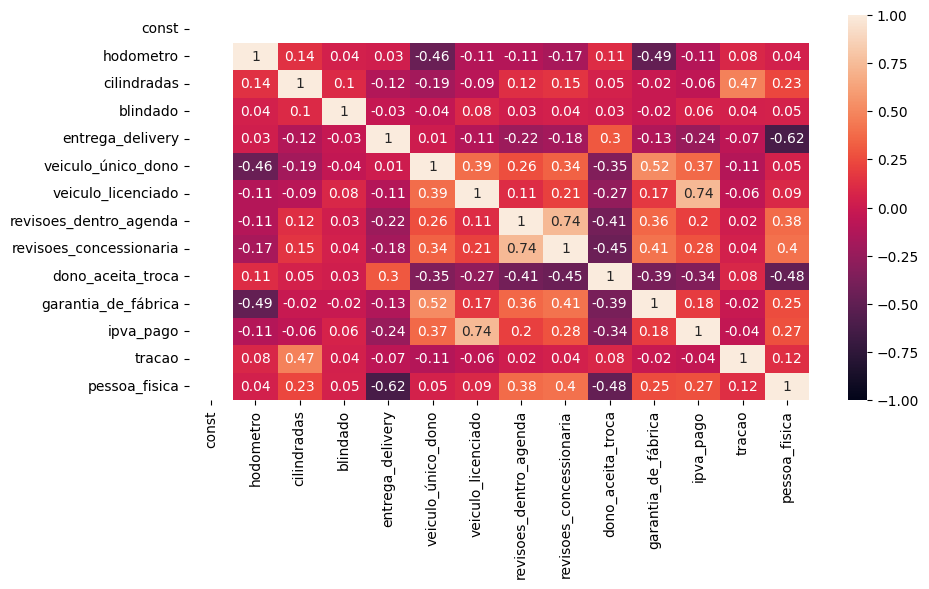

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
df = df_train[numericas+booleanas]
X = df.drop(['preco', 'ano_de_fabricacao','num_fotos','troca','ano_modelo'], axis=1)

# Adicione uma constante ao conjunto de dados (opcional, dependendo do modelo que será utilizado)
X = sm.add_constant(X)

# Calculando o VIF para cada variável independente
vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.options.display.float_format = '{:.4f}'.format

print(vif)

plt.figure(figsize=(10,5))
sns.heatmap(X.corr(method='spearman').round(2), vmin=-1, vmax=1, annot=True);
plt.show

O VIF (Variance Inflation Factor ou ) é uma medida estatística que quantifica o grau de multicolinearidade entre as variáveis independentes. Analisando os VIF das variáveis numéricas e booleanas, optei por retirar apenas as colunas:
* `ano_de_fabricacao`
* `num_fotos`
* `troca`

Apesar da retirada da coluna `ano_modelo` diminuir significativamente o VIF, ele já estava aceitável antes de sua retirada. Além disso, o modelo do carro parece conceitualmente relevante, assim como os quilômetros rodados no `hodometro`. Sendo assim, manteremos ambos.

In [ ]:
df_train.drop(['ano_de_fabricacao','num_fotos','troca'],inplace=True,axis=1)
df_test.drop(['ano_de_fabricacao','num_fotos','troca'],inplace=True,axis=1)
numericas.remove('ano_de_fabricacao')
numericas.remove('num_fotos')
booleanas.remove('troca')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   marca                    29584 non-null  object 
 1   modelo                   29584 non-null  object 
 2   ano_modelo               29584 non-null  float64
 3   hodometro                29584 non-null  float64
 4   cambio                   29584 non-null  object 
 5   num_portas               29584 non-null  int64  
 6   tipo                     29584 non-null  object 
 7   blindado                 29584 non-null  int64  
 8   cor                      29584 non-null  object 
 9   cidade_vendedor          29584 non-null  object 
 10  estado_vendedor          29584 non-null  object 
 11  anunciante               29584 non-null  object 
 12  entrega_delivery         29584 non-null  int64  
 13  dono_aceita_troca        29584 non-null  int64  
 14  veiculo_único_dono    

<function matplotlib.pyplot.show(close=None, block=None)>

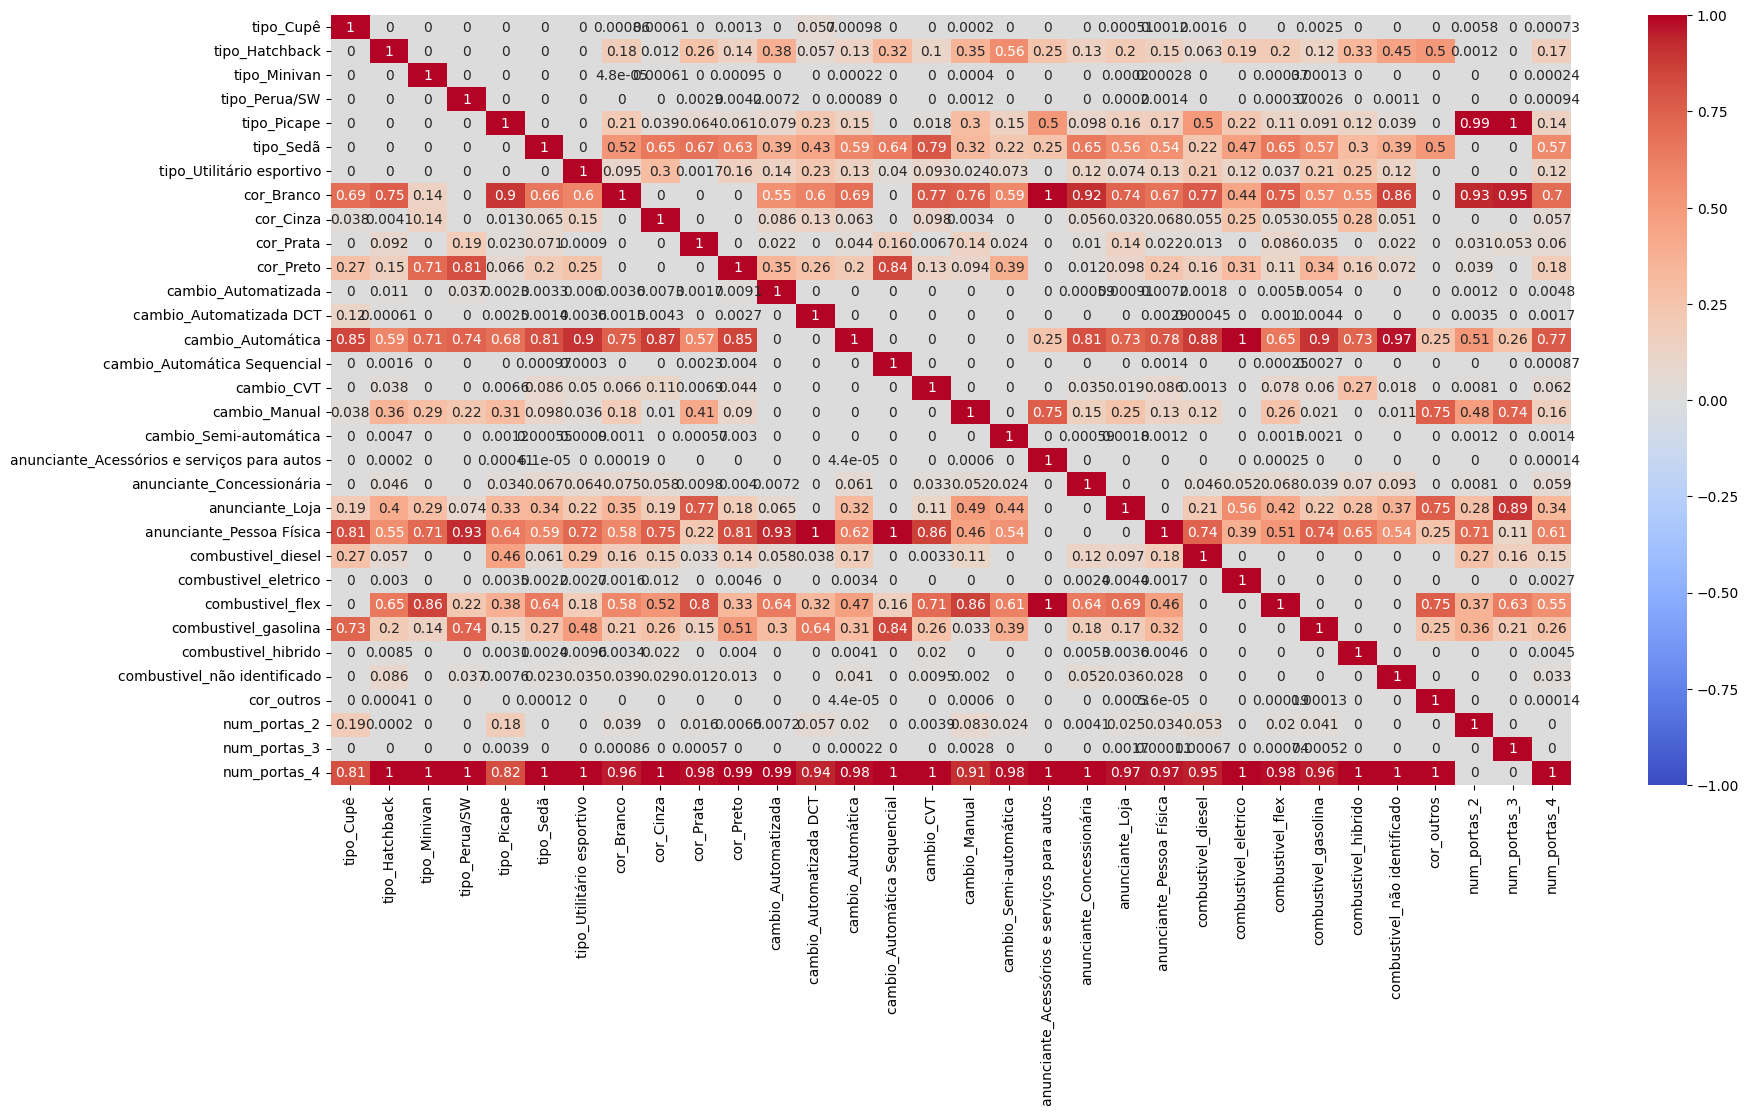

In [ ]:
# calculando correlação entre as variáveis categóricas
import scipy.stats as ss
import seaborn as sns

def percent_true_positives(x, y):
    true_positives = np.sum((x == 1) & (y == 1))
    total_positives = np.sum(y == 1)
    return true_positives / total_positives
plt.figure(figsize=(20,10))

df_encoded = pd.get_dummies(df_train[categoricas])
df_encoded['cor_outros']=np.where((df_encoded['cor_Vermelho'] | df_encoded['cor_Verde'] | df_encoded['cor_Dourado']), 1, 0)
df_encoded.drop(['cor_Vermelho','cor_Verde','cor_Dourado'],axis=1,inplace=True)
df_encoded['num_portas_2']=np.where(df_encoded['num_portas'] == 2, 1, 0)
df_encoded['num_portas_3']=np.where(df_encoded['num_portas'] == 3, 1, 0)
df_encoded['num_portas_4']=np.where(df_encoded['num_portas'] == 4, 1, 0)
df_encoded.drop(['num_portas'],axis=1,inplace=True)

data = []
contador_1=-1
for i in df_encoded.columns:
  data.append([])
  contador_1+=1
  for j in df_encoded.columns:
    data[contador_1].append(percent_true_positives(df_encoded[i], df_encoded[j]))
sns.heatmap(pd.DataFrame(data, columns=df_encoded.columns, index=df_encoded.columns), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show


Percepções:
* Todos os 19 registros com 3 portas são picapes
* Praticamente todos os 868 registros com 2 portas também são picapes, mas ainda há muitas picapes com 4 portas.
* Quase todos os carros têm 4 portas e a grande maioria tem câmbio automático e são anunciados por pessoa física
* Todos os 4 carros anunciados por "Acessórios e serviços para autos" são brancos e têm combustível flex. 3 deles têm câmbio manual.
* Quase todos os carros com combustível elétrico ou não identificado e quase todos os carros esportivos têm câmbio automático.
* Todos os carros com câmbio automático sequencial ou Automatizado DCT são anunciados por pessoa física

A seguir analisaremos os boxplots das features numéricas, para analisar a presença de outliers ou algum insight interessante.

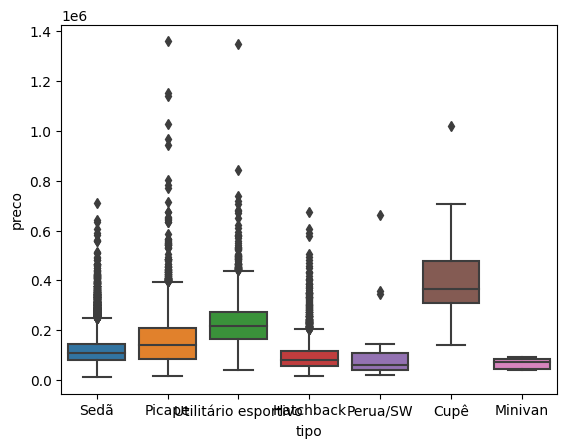

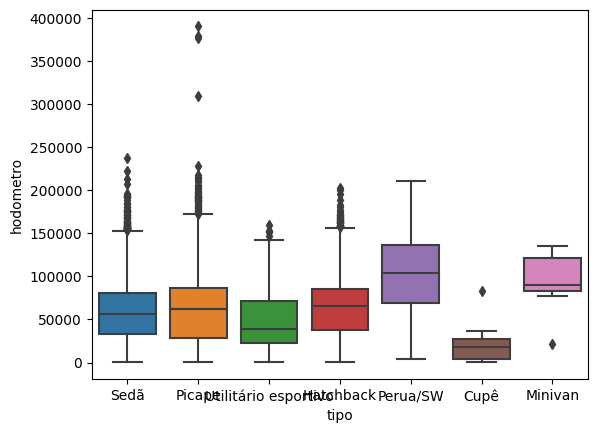

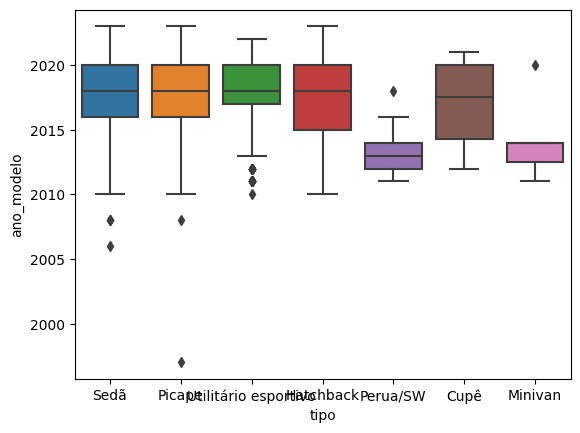

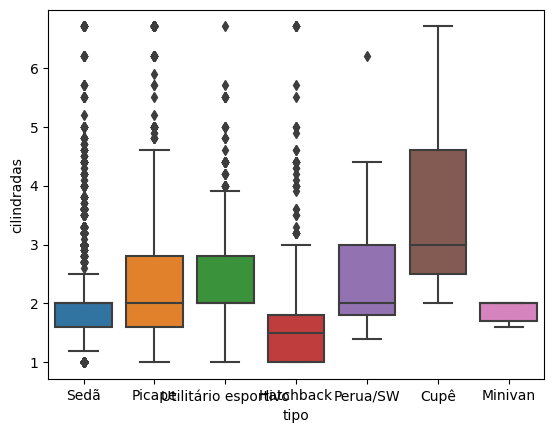

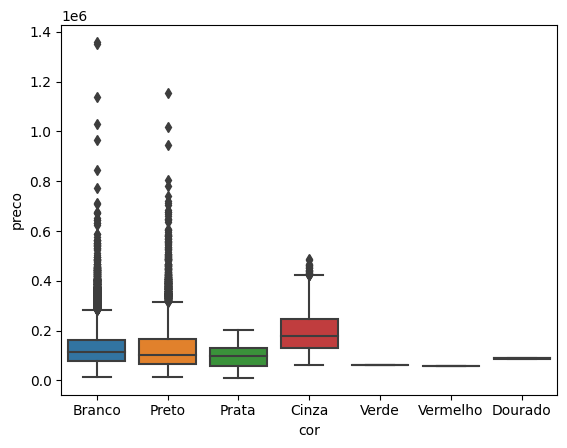

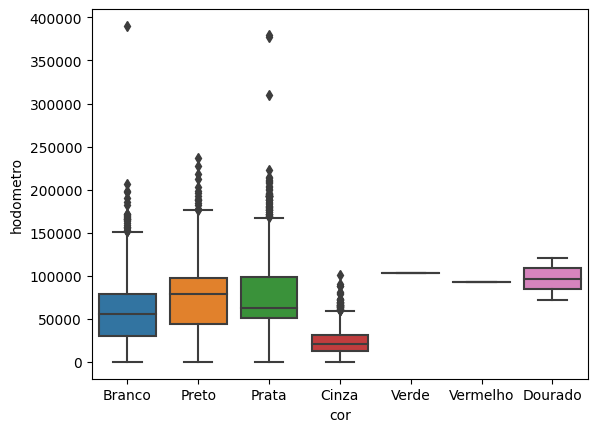

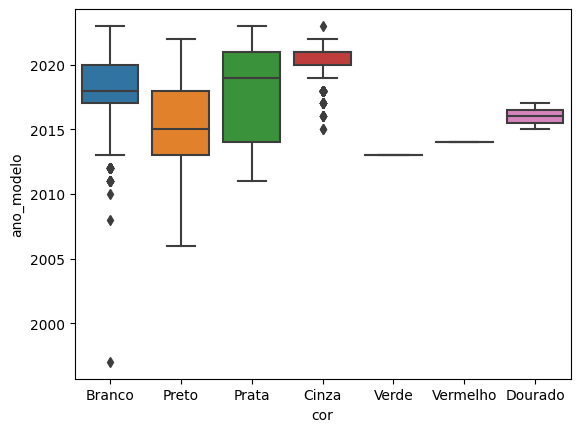

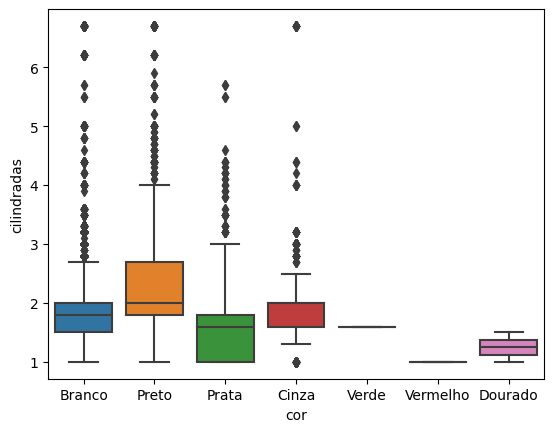

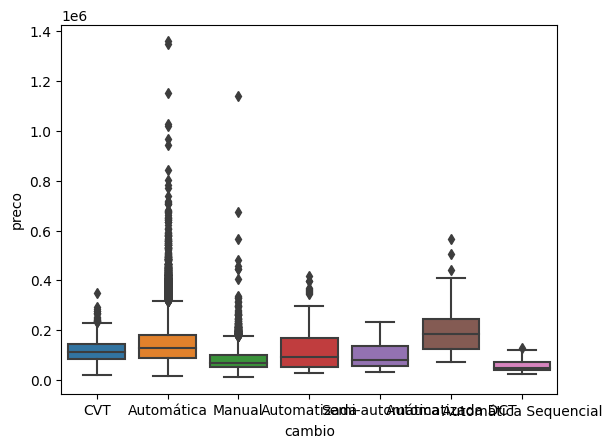

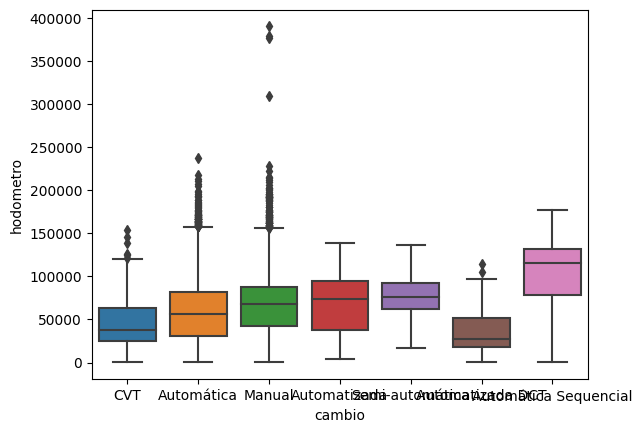

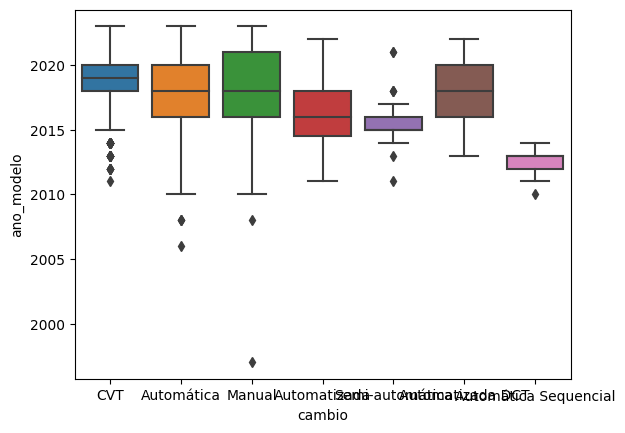

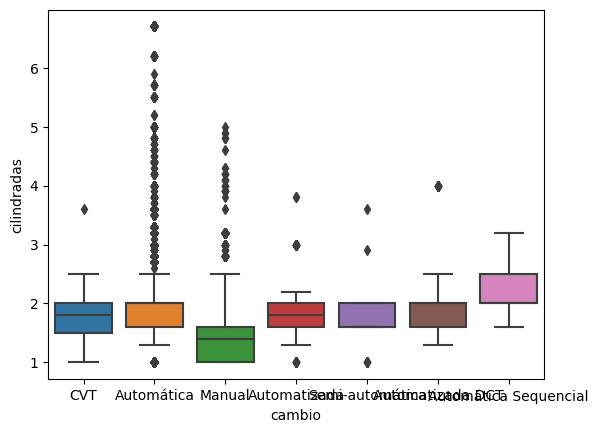

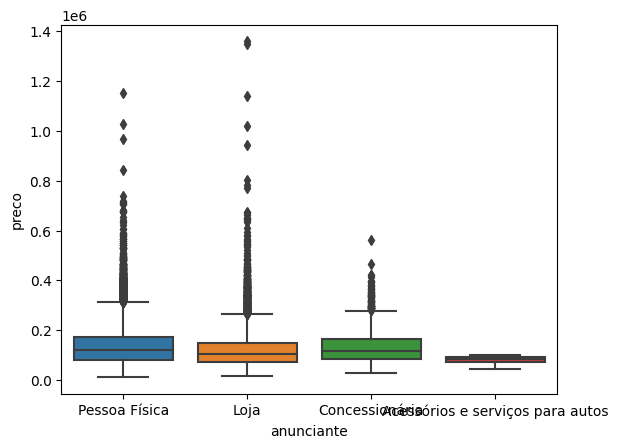

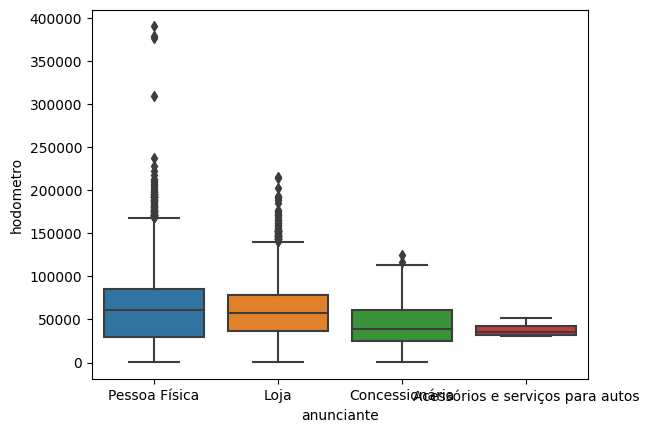

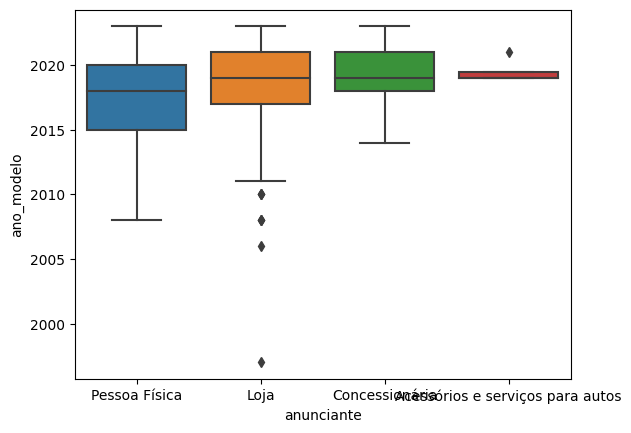

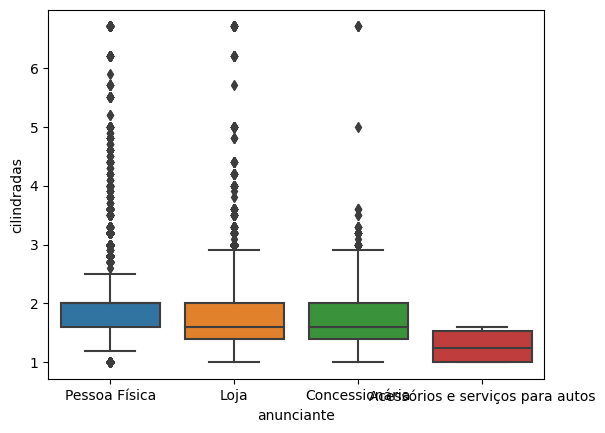

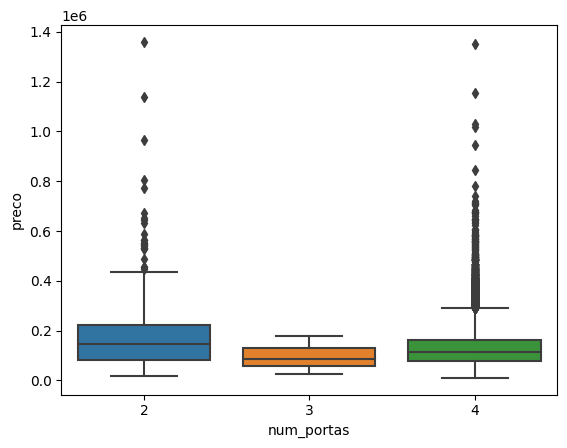

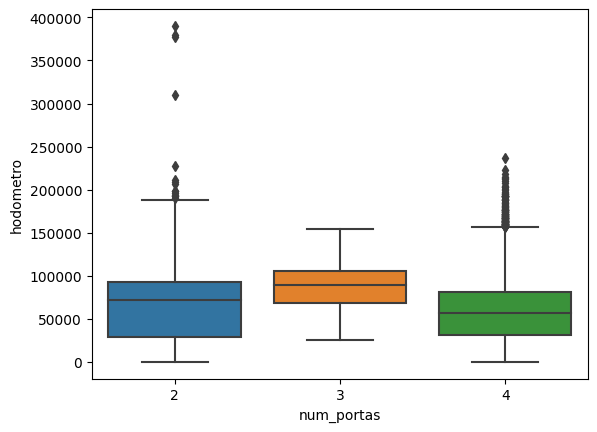

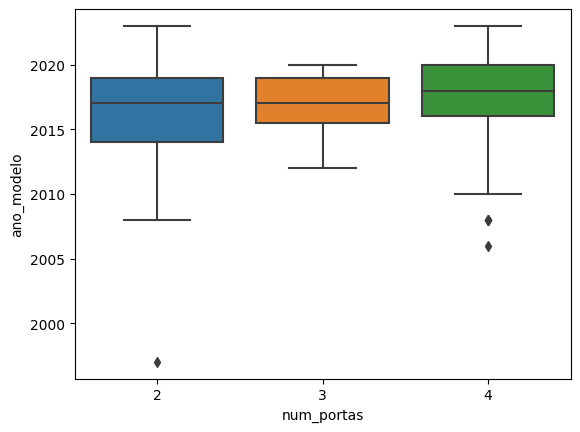

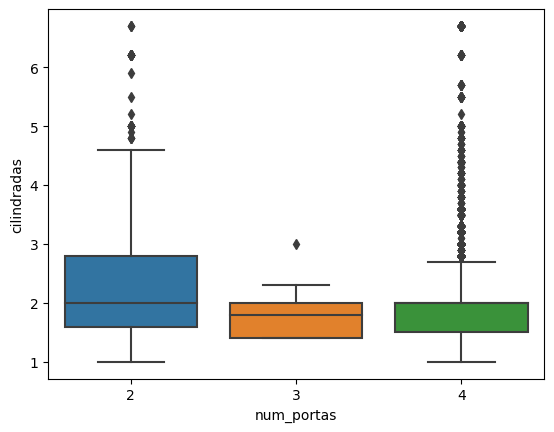

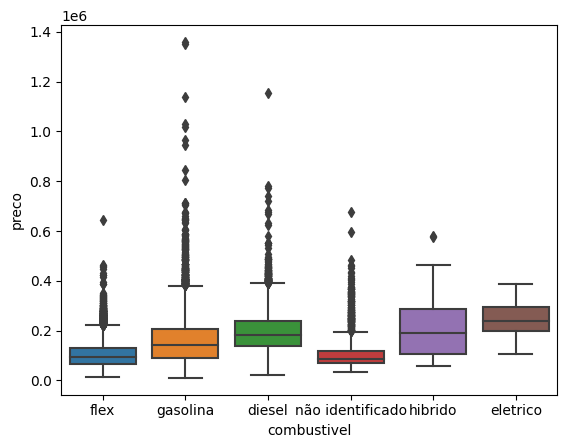

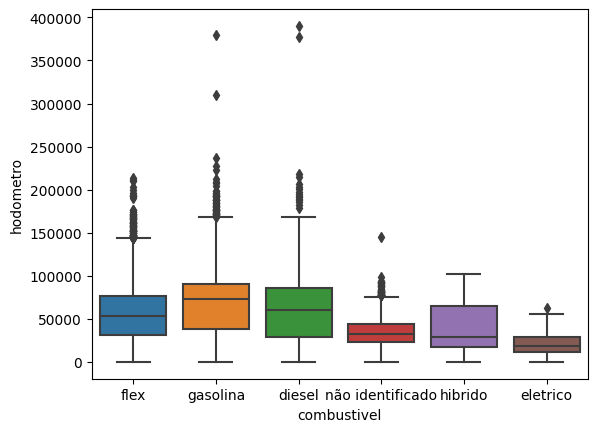

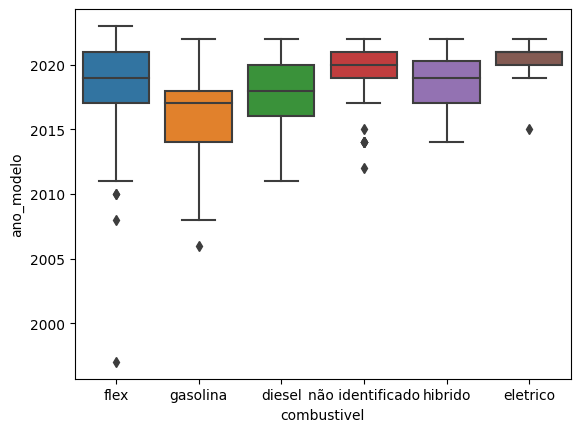

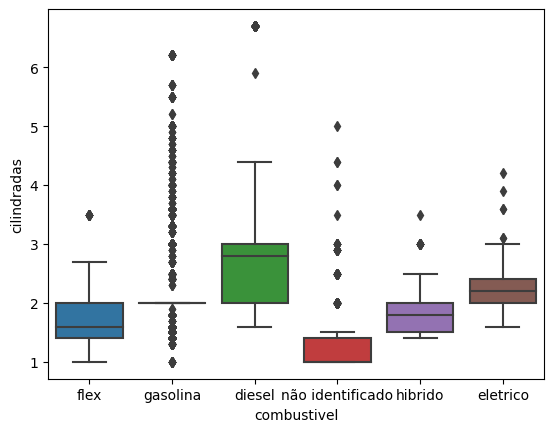

In [ ]:
df=df_train
for i in categoricas:
    for j in numericas:
        sns.boxplot(data=df, x=i, y=j)
        plt.show()

Percepções:
* Em `cor X ano_modelo`, vemos que há vários outliers nos carros branco e cinza. Em especial, há um carro branco com modelo anterior a 2000, que é o único no banco de dados. Em `tipo X ano_modelo`, vemos que esse carro é uma picape.
* Em `tipo X hodometro`, vemos que peruas têm uma quilometragem bem maior que os demais. Isso pode ter contribuido para o baixo valor de venda desse tipo de veículo.
* Em `cor X ano_modelo`,vemos como a fabricação de carros prata, brancos e, especiamente, cinzas, se intensificou há pouco tempo. E, aparentemente, carros pretos são atemporais.
* Em `combustivel X hodometro` e `combustivel X ano_modelo`, vemos que carros a gasolina são modelos mais antigos e rodaram mais.
* Em `combustivel X cilindradas`, vemos que veículos a diesel tendem a ter mais cilindradas.



# Hipóteses e perguntas de negócio

No início da análise, nossas hipóteses foram:
* Carros com mais cilindradas tendem a ter preços maiores.
* Carros elétricos tendem a ter preços maiores.
* Carros mais velhos tendem a ter um maior valor no hodometro e preços menores.

Resumindo o que encontramos durante nossa análise, temos:
* Apesar das cilindradas terem alguma relação com o preço do carro, o tipo do carro tem ainda mais importância. Carros com mais cilindradas não são do tipo Cupê, o tipo mais caro de carro. Além disso, como carros elétricos não têm cilindradas, os valores para esse tipo de carro precisaram ser calculados a partir do preço, causando um ruído para carros elétricos.
* Vimos que essa hipótese mostrou-se verdadeira. Seguidos de carros híbridos e a diesel.
* Essa hipótese também se mostrou verdadeira. Também encontramos um problema quanto às features `ano_de_fabricacao` e `ano_modelo`.

Agora, vamos responder a algumas perguntas do negócio:

* Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?
* Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?
* Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?

## Pergunta 1: Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?

Carros que estamos considerando 'populares' são carros cujo modelo possui preço médio menor que R$51361.01.
Considerando a quantidade bruta de venda:


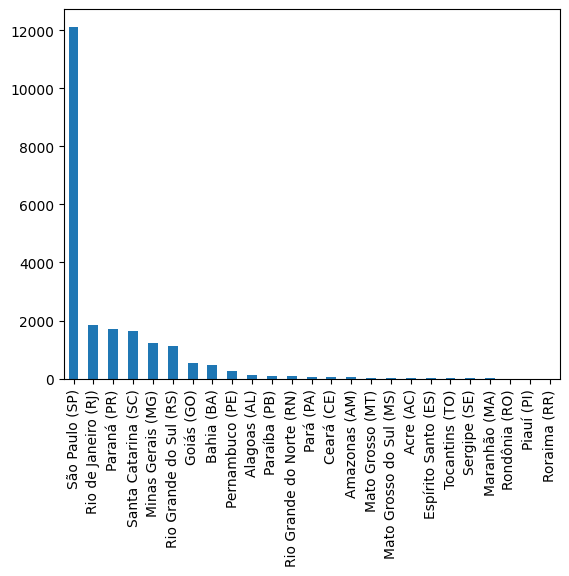

São Paulo (SP)              12118
Rio de Janeiro (RJ)          1850
Paraná (PR)                  1719
Santa Catarina (SC)          1630
Minas Gerais (MG)            1235
Rio Grande do Sul (RS)       1116
Goiás (GO)                    527
Bahia (BA)                    455
Pernambuco (PE)               248
Alagoas (AL)                  109
Paraíba (PB)                   93
Rio Grande do Norte (RN)       78
Pará (PA)                      69
Ceará (CE)                     64
Amazonas (AM)                  48
Mato Grosso (MT)               31
Mato Grosso do Sul (MS)        27
Acre (AC)                      25
Espírito Santo (ES)            20
Tocantins (TO)                 19
Sergipe (SE)                   18
Maranhão (MA)                   7
Rondônia (RO)                   4
Piauí (PI)                      3
Roraima (RR)                    2
Name: estado_vendedor, dtype: int64
Considerando a quantidade percentual de venda de carros populares em relação à venda de carros quaisquer:


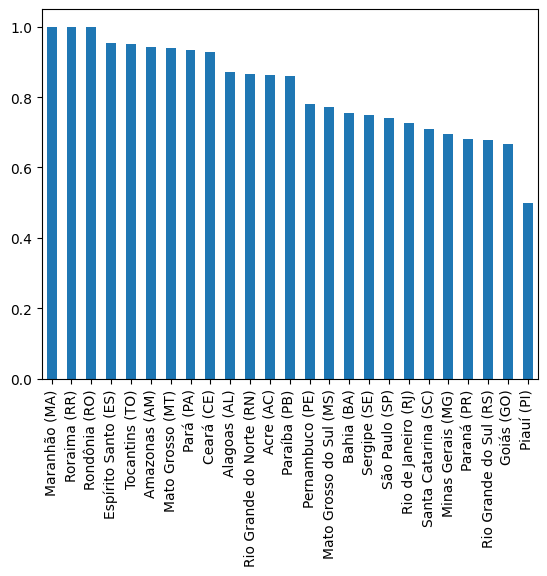

Maranhão (MA)              1.0000
Roraima (RR)               1.0000
Rondônia (RO)              1.0000
Espírito Santo (ES)        0.9524
Tocantins (TO)             0.9500
Amazonas (AM)              0.9412
Mato Grosso (MT)           0.9394
Pará (PA)                  0.9324
Ceará (CE)                 0.9275
Alagoas (AL)               0.8720
Rio Grande do Norte (RN)   0.8667
Acre (AC)                  0.8621
Paraíba (PB)               0.8611
Pernambuco (PE)            0.7799
Mato Grosso do Sul (MS)    0.7714
Bahia (BA)                 0.7533
Sergipe (SE)               0.7500
São Paulo (SP)             0.7399
Rio de Janeiro (RJ)        0.7261
Santa Catarina (SC)        0.7081
Minas Gerais (MG)          0.6958
Paraná (PR)                0.6805
Rio Grande do Sul (RS)     0.6780
Goiás (GO)                 0.6679
Piauí (PI)                 0.5000
Name: estado_vendedor, dtype: float64


In [ ]:
media_preco = df_train.groupby('modelo')['preco'].mean()
#display(media_preco.sort_values())

media_preco = df_train['preco'].mean()
desvio_padrao_preco = df_train['preco'].std()
limite_inferior = media_preco - desvio_padrao_preco

carros_abaixo_limite = df_train.loc[df_train['preco'] < limite_inferior, 'modelo'].unique()
#print("Média dos preços totais:", media_preco)
print(f"Carros que estamos considerando 'populares' são carros cujo modelo possui preço médio menor que R${limite_inferior:.2f}.")
# print(carros_abaixo_limite)

print('Considerando a quantidade bruta de venda:')
contagem_carros_estado = df_train[df_train['modelo'].isin(carros_abaixo_limite)]['estado_vendedor'].value_counts()
contagem_carros_estado.plot(kind='bar')
plt.show()
print(contagem_carros_estado)

#SP é o estado que mais vende carros, como esperado.
#Mas, vamos entender a porcentagem de carros populares em relação à venda total de carros em cada estado.

print('Considerando a quantidade percentual de venda de carros populares em relação à venda de carros quaisquer:')
porcentagem_carros_estado = contagem_carros_estado/df_train['estado_vendedor'].value_counts()
porcentagem_carros_estado=porcentagem_carros_estado.sort_values(ascending=False)
porcentagem_carros_estado.plot(kind='bar')
plt.show()
print(porcentagem_carros_estado)


Resposta:
Considerando que carros populares são os carros com preço menor que `R$51361.01`, o estado que mais vende carros populares em quantidade é São Paulo.

Por outro lado, considerando a proporção de venda de carros populares em relação às vendas totais, os estados de Maranhão, Roraima e Rondônia vendem mais (com `100%` das vendas sendo em carros populares), mas isso dá um total de `13` carros num universo de mais de `1800` carros populares vendidos no resto do país.

Encontrando um meio termo, temos os estados do Pará (onde `93%` dos carros vendidos são populares e isso equivale `69` de `1800` carros) e da Bahia (onde `75%` dos carros vendidos são populares e isso equivale a `455` dos `1800`).



## Pergunta 2: Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?

Quantidade de carros desse tipo vendidos por estado:
São Paulo (SP)              1712
Paraná (PR)                  348
Rio de Janeiro (RJ)          318
Santa Catarina (SC)          283
Minas Gerais (MG)            211
Rio Grande do Sul (RS)       198
Goiás (GO)                   102
Bahia (BA)                    68
Pernambuco (PE)               14
Alagoas (AL)                  12
Acre (AC)                      6
Mato Grosso (MT)               6
Mato Grosso do Sul (MS)        5
Sergipe (SE)                   5
Paraíba (PB)                   4
Piauí (PI)                     4
Tocantins (TO)                 3
Rio Grande do Norte (RN)       1
Espírito Santo (ES)            0
Ceará (CE)                     0
Amazonas (AM)                  0
Pará (PA)                      0
Rondônia (RO)                  0
Roraima (RR)                   0
Maranhão (MA)                  0
Name: estado_vendedor, dtype: int64
Agora vamos analisar como se comporta estatisticamente o preço em cada estado:


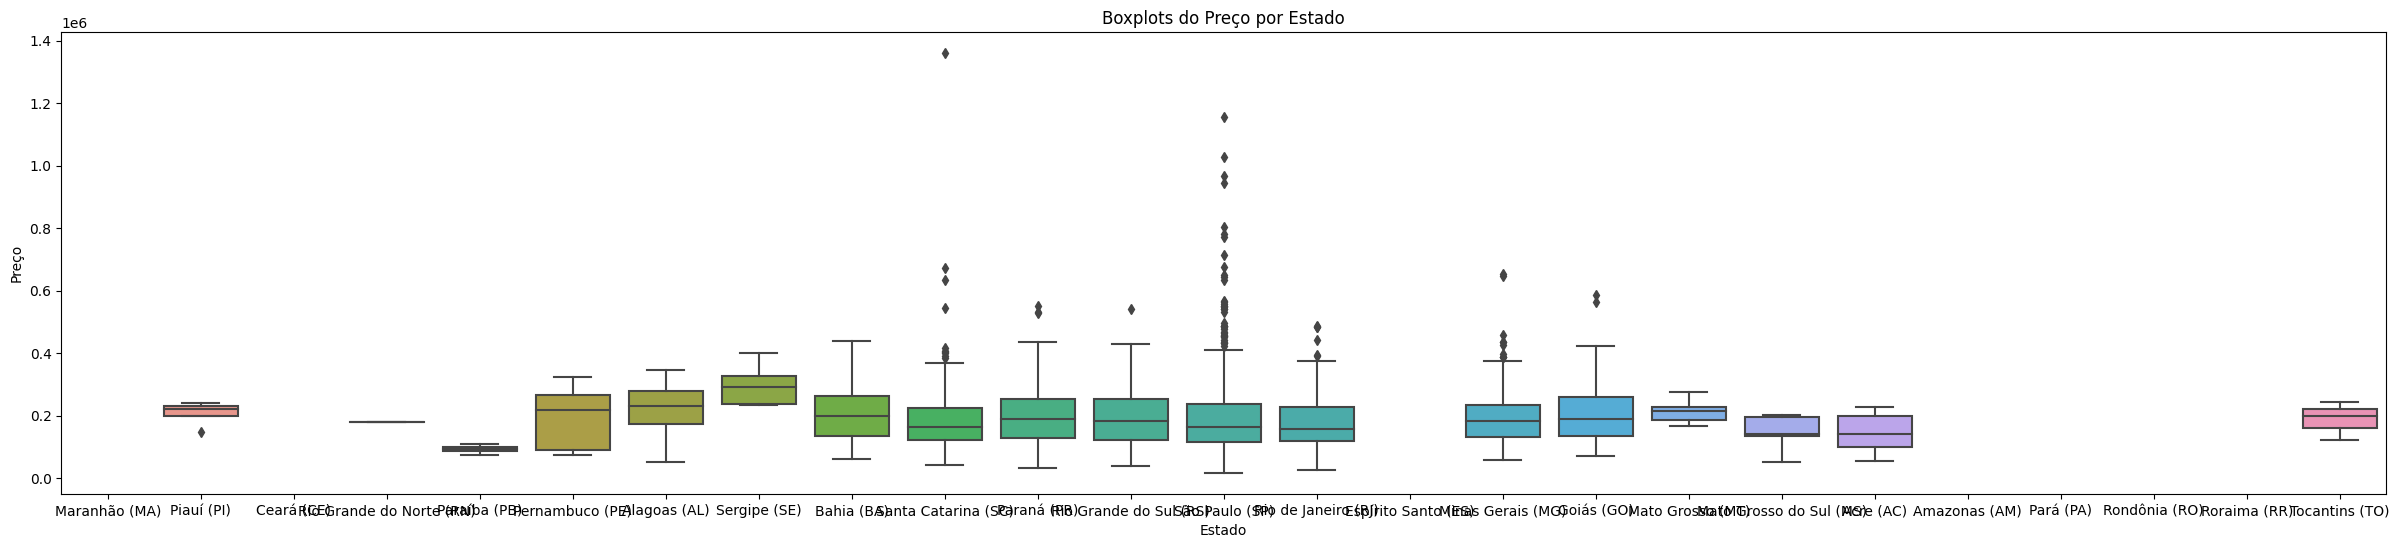

Primeira abordagem: Considerando que o comprador não vai comprar o mais barato e vai comprar considerando outros fatores.
estado_vendedor
Paraíba (PB)                93157.0353
Mato Grosso do Sul (MS)    144700.2476
Acre (AC)                  145256.6937
Rio Grande do Norte (RN)   179961.6948
Rio de Janeiro (RJ)        181660.3447
Santa Catarina (SC)        185848.6185
Tocantins (TO)             187717.1275
São Paulo (SP)             188427.4846
Pernambuco (PE)            192566.7645
Rio Grande do Sul (RS)     195251.7631
Minas Gerais (MG)          195702.9148
Paraná (PR)                198384.9496
Bahia (BA)                 206364.7992
Goiás (GO)                 208153.6584
Piauí (PI)                 208181.0778
Mato Grosso (MT)           214102.3156
Alagoas (AL)               218671.5428
Sergipe (SE)               298195.3097
Maranhão (MA)                      NaN
Ceará (CE)                         NaN
Espírito Santo (ES)                NaN
Amazonas (AM)                      NaN
Pará

In [ ]:
# Agora queremos minimizar o preço para carros do tipo "picape" e com câmbio "automática"
# Primeiro, vamos ver quantos carros existem nesse grupo em cada estado do nosso banco de dados.
dados_filtrados = df_train[(df_train['tipo']=='Picape') & (df_train['cambio']=='Automática')]
print('Quantidade de carros desse tipo vendidos por estado:')
print(dados_filtrados['estado_vendedor'].value_counts())

print('Agora vamos analisar como se comporta estatisticamente o preço em cada estado:')
plt.figure(figsize=(30, 6))
sns.boxplot(data=dados_filtrados, x='estado_vendedor', y='preco')
plt.title('Boxplots do Preço por Estado')
plt.xlabel('Estado')
plt.ylabel('Preço')
plt.show()

print('Primeira abordagem: Considerando que o comprador não vai comprar o mais barato e vai comprar considerando outros fatores.')
dados_ordenados = dados_filtrados.groupby('estado_vendedor')['preco'].mean().sort_values()
print(dados_ordenados)

print('Segunda abordagem: Considerando que o comprador vai comprar o mais barato, independente das condições.')
print(dados_filtrados[['tipo','cambio','marca','modelo','estado_vendedor','preco']].nsmallest(5, 'preco'))

Resposta:
Considerando a primeira abordagem, supondo que o comprador não vai comprar o mais barato e vai comprar considerando outros fatores, creio que o mais sensato seria considerar a média de preços.
Com essa abordagem, o lugar mais vantajoso pra se comprar uma picape com câmbio automático seria na Paraíba, onde esse tipo de picape tem um preço médio muito inferior aos demais lugares. Porém, em toda nossa base de dados, há apenas 4 picapes desse tipo que foram vendidas na Paraíba.

Por outro lado, o Rio de Janeiro é o 5º lugar mais barato para esse tipo de picape (embora elas tenham o dobro do preço) e é o terceiro estado que mais vende picapes com esse preço. Se o comprador deseja ter mais opções de compra ou comprar uma quantidade maior de picapes, o Rio de Janeiro me parece o estado mais promissor.

Considerando a segunda abordagem, onde o comprador deseja comprar apenas uma picape com câmbio automático e irá buscar a picape com o menor preço de todos, independente das demais condições, há uma opção registrada por 15 mil reais, outra por 25 mil e outra por 26 mil. Mas, vendo suas marcas e modelos, elas não são picapes de verdade. Portanto, a picape com câmbio automático mais barata do banco inteiro é a Dodge Dakota, por R$ 29.327 e fica no estado de São Paulo.




## Pergunta 3: Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?

Porcentagem de carros dentro da garantia de fábrica vendidos por estado:
São Paulo (SP)             52.8522
Rio de Janeiro (RJ)         9.4387
Paraná (PR)                 8.9118
Santa Catarina (SC)         7.5601
Rio Grande do Sul (RS)      6.4376
Minas Gerais (MG)           6.0481
Goiás (GO)                  4.2612
Alagoas (AL)                1.3288
Bahia (BA)                  1.1684
Pernambuco (PE)             0.4582
Pará (PA)                   0.3895
Mato Grosso do Sul (MS)     0.2978
Amazonas (AM)               0.2062
Rio Grande do Norte (RN)    0.2062
Espírito Santo (ES)         0.2062
Sergipe (SE)                0.0687
Acre (AC)                   0.0458
Mato Grosso (MT)            0.0458
Tocantins (TO)              0.0229
Paraíba (PB)                0.0229
Ceará (CE)                  0.0229
Piauí (PI)                  0.0000
Rondônia (RO)               0.0000
Roraima (RR)                0.0000
Maranhão (MA)               0.0000
Name: estado_vendedor, dtype: float64
Quantidade de 

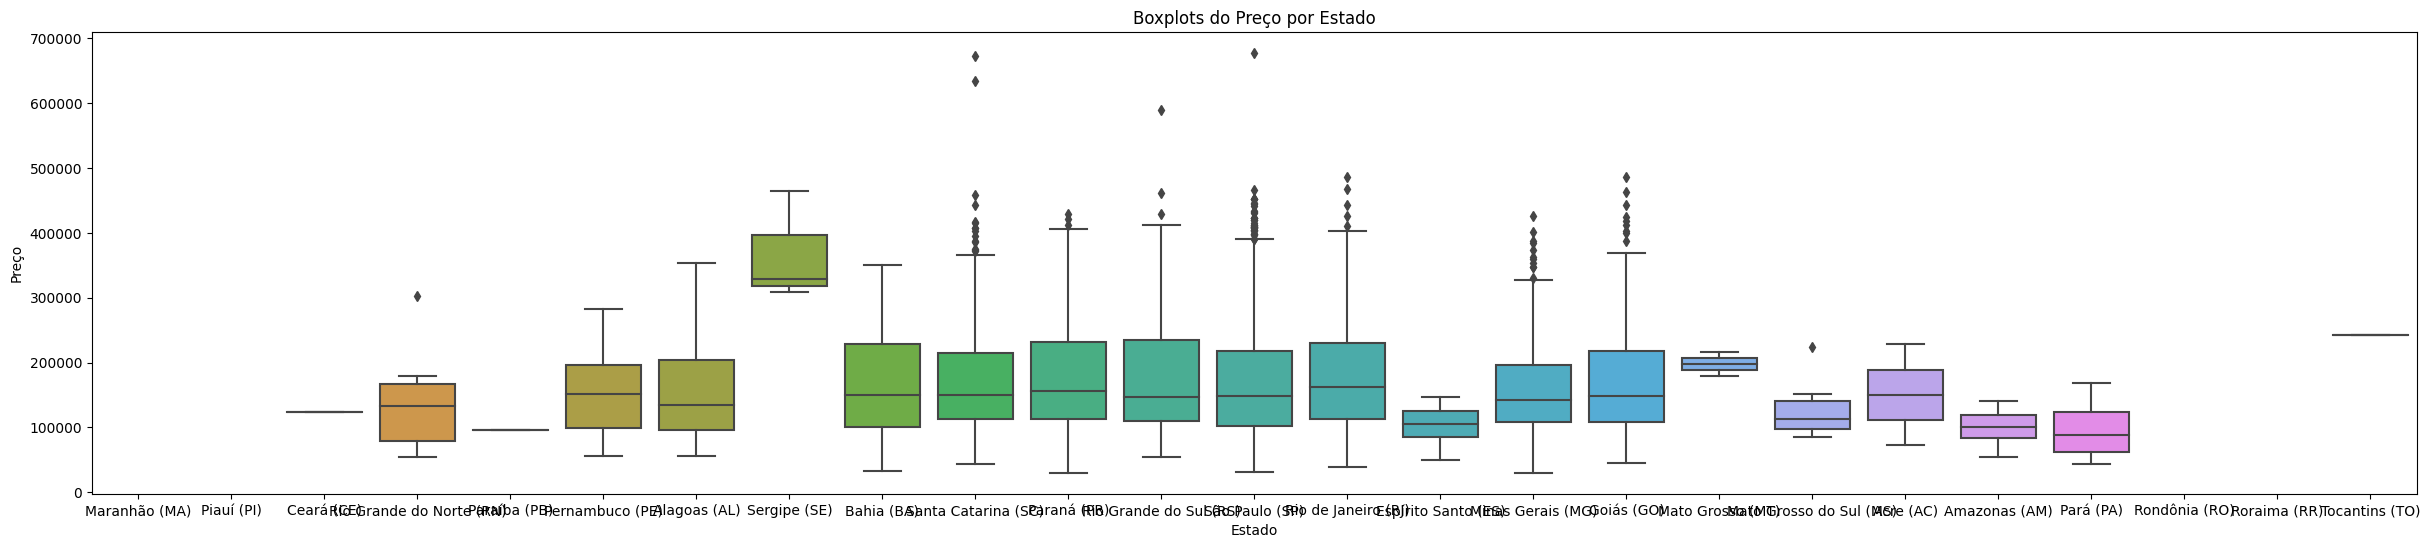

Agora, repetiremos a primeira abordagem da pergunta anterior.
Analisaremos o preço, supondo que há outras features a serem levadas em conta.
Vamos buscar minimizar a média de preços por estado.
estado_vendedor
Paraíba (PB)                95762.7466
Pará (PA)                   98156.6153
Amazonas (AM)               99617.3033
Espírito Santo (ES)        104030.2081
Mato Grosso do Sul (MS)    121709.5898
Ceará (CE)                 123939.8788
Rio Grande do Norte (RN)   133120.3939
Pernambuco (PE)            149898.4169
Acre (AC)                  150416.9113
Alagoas (AL)               154268.6765
Minas Gerais (MG)          161206.2739
Bahia (BA)                 165221.2362
São Paulo (SP)             166751.0810
Santa Catarina (SC)        173798.4399
Goiás (GO)                 174521.4132
Paraná (PR)                175578.2455
Rio Grande do Sul (RS)     176442.2365
Rio de Janeiro (RJ)        179109.8584
Mato Grosso (MT)           197657.0666
Tocantins (TO)             243002.2170
Sergipe (S

In [ ]:
# Nosso objetivo é minimizar o preço de carros dentro da garantia de fábrica.

dados_filtrados = df_train[df_train['garantia_de_fábrica']==1]
print('Porcentagem de carros dentro da garantia de fábrica vendidos por estado:')
print(dados_filtrados['estado_vendedor'].value_counts(normalize=True)*100)
print('Quantidade de carros dentro da garantia de fábrica vendidos por estado:')
print(dados_filtrados['estado_vendedor'].value_counts())

print('Certamente a melhor variedade desse tipo de carro existirá em São Paulo.')
print('Além de SP, os 3 estados do sul, RJ, MG e GO podem representar boas opções para esse tipo de carro, levando em conta a variedade.')

print('Agora vamos analisar como se comporta estatisticamente o preço em cada estado:')
plt.figure(figsize=(30, 6))
sns.boxplot(data=dados_filtrados, x='estado_vendedor', y='preco')
plt.title('Boxplots do Preço por Estado')
plt.xlabel('Estado')
plt.ylabel('Preço')
plt.show()

print('Agora, repetiremos a primeira abordagem da pergunta anterior.\n'+
      'Analisaremos o preço, supondo que há outras features a serem levadas em conta.\n'+
      'Vamos buscar minimizar a média de preços por estado.')
dados_ordenados = dados_filtrados.groupby('estado_vendedor')['preco'].mean().sort_values()
print(dados_ordenados)



print('Segunda abordagem: Considerando que o comprador vai comprar o mais barato, independente das condições.')
print(dados_filtrados[['tipo','garantia_de_fábrica','marca','modelo','estado_vendedor','preco']].nsmallest(5, 'preco'))

Considerando a primeira abordagem, só existe um registro da Paraíba de veículos com garantia de fábrica, não é interessante levar esse registro em consideração estatisticamente.

O Pará vendeu `17` veículos e a média de preço é apenas `3 mil reais` acima do preço da Paraíba. Sendo, assim, uma melhor opção para compra de um carro desse tipo.

Caso a ideia seja comprar vários carros, Minas Gerais parece mais promissor, pois vendeu `264` veículos com garantia de fábrica (`6%` do total de vendas desse tipo de veículo), o que indica que há mais veículos com garantia de fábrica à venda nesse estado, além de indicar mais opções e variedade para a compra.

Considerando a segunda abordagem, supondo que o comprador queira apenas encontrar um único veículo, que seja o mais barato com garantia de fábrica, independente de outras features, a primeira escolha é um `Peugeout 307`, no Paraná, por `R$29.328,11`.

# Preparando os dados para começar a usar os modelos


## Escolhendo a métrica a ser utilizada: MAE

Creio que o erro absoluto médio (MAE) seja a métrica mais adequada para avaliar o desempenho do modelo de predição de preços de carros.

O MAE calcula a média das diferenças absolutas entre as predições do modelo e os valores reais dos preços dos carros, fornecendo assim uma medida direta do tamanho médio do erro cometido pelo modelo, sem atribuir pesos diferentes aos erros com base na magnitude como o MSE.

Assim, reduziremos a diferença entre os preços preditos pelo modelo e os valores reais dos carros.

## Limpando e dividindo os dados

Encontrando soluções para campos categóricos com muitos valores distintos.

* Para a coluna `estado_vendedor`, podemos substituir pela região do país em que está cada estado. Vamos analisar um pouco mais essa opção observando alguns boxplots de como o preço dos carros se comporta em cada estado e em cada região.
* Para as colunas `cidade_vendedor` e `modelo`, não vimos outra alternativa a não ser eliminá-las. O `modelo` pode ser útil para determinar o valor do carro, mas é muito restritivo. Quando forem lançados modelos novos, não haveria como calcular o `preco` para eles. Há outras características mais abrangentes e gerais que resumem de forma satisfatória características implícitas no modelo (como cilindradas, tipo de combustível, tipo de câmbio, etc).
* Transformaremos a coluna "num_portas" em uma coluna categórica, já que a característica neste banco está intimamente ligada ao tipo do carro (especialmente `picape`). Num banco com carros mais antigos ou mais populares, talvez fizesse mais sentido tratar essa coluna como uma coluna numérica.

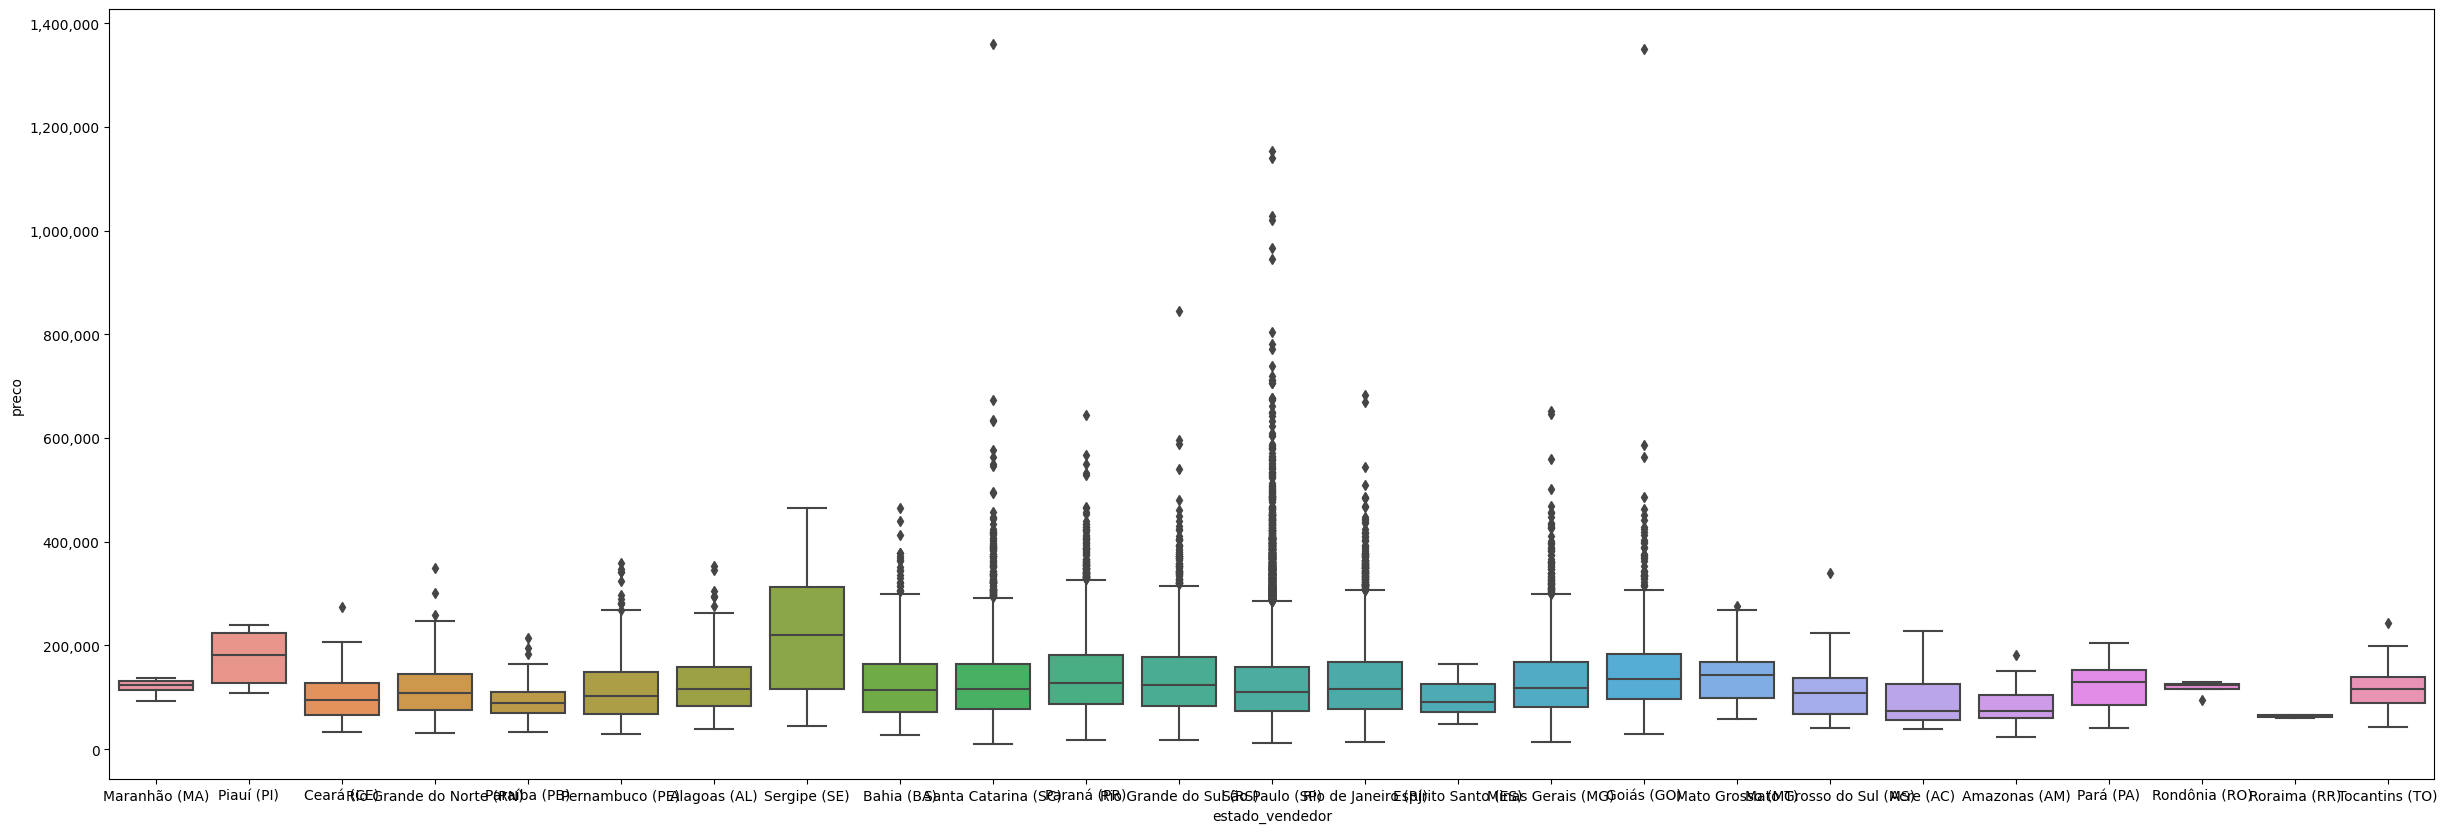

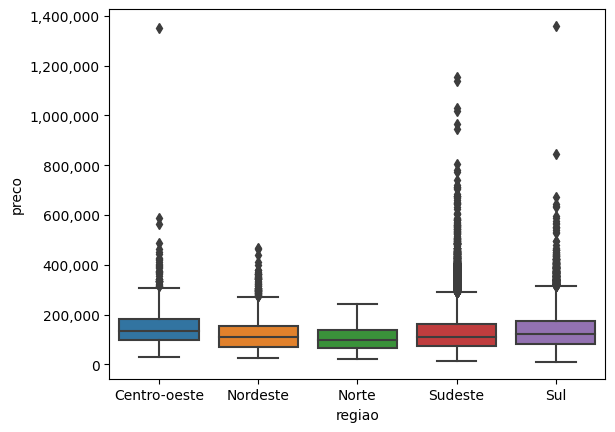

                               preco  estado_vendedor
Maranhão (MA)            121041.6891                7
Piauí (PI)               177119.4509                6
Ceará (CE)               102755.6633               69
Rio Grande do Norte (RN) 115937.0743               90
Paraíba (PB)              94476.4790              108
Pernambuco (PE)          117126.4884              318
Alagoas (AL)             129906.5534              125
Sergipe (SE)             218926.3556               24
Bahia (BA)               129285.7333              604
Santa Catarina (SC)      134442.6211             2302
Paraná (PR)              145463.0028             2526
Rio Grande do Sul (RS)   141426.4024             1646
São Paulo (SP)           129756.6928            16378
Rio de Janeiro (RJ)      134959.8226             2548
Espírito Santo (ES)       96534.3739               21
Minas Gerais (MG)        134881.9404             1775
Goiás (GO)               153416.0879              789
Mato Grosso (MT)         143

In [ ]:
mapeamento_regioes = {
    'Maranhão (MA)': 'Nordeste',
    'Piauí (PI)': 'Nordeste',
    'Ceará (CE)': 'Nordeste',
    'Rio Grande do Norte (RN)': 'Nordeste',
    'Paraíba (PB)': 'Nordeste',
    'Pernambuco (PE)': 'Nordeste',
    'Alagoas (AL)': 'Nordeste',
    'Sergipe (SE)': 'Nordeste',
    'Bahia (BA)': 'Nordeste',
    'Santa Catarina (SC)': 'Sul',
    'Paraná (PR)': 'Sul',
    'Rio Grande do Sul (RS)': 'Sul',
    'São Paulo (SP)': 'Sudeste',
    'Rio de Janeiro (RJ)': 'Sudeste',
    'Espírito Santo (ES)': 'Sudeste',
    'Minas Gerais (MG)': 'Sudeste',
    'Goiás (GO)': 'Centro-oeste',
    'Mato Grosso (MT)': 'Centro-oeste',
    'Mato Grosso do Sul (MS)': 'Centro-oeste',
    'Acre (AC)': 'Norte',
   # 'Amapá (AP)': 'Norte',
    'Amazonas (AM)': 'Norte',
    'Pará (PA)': 'Norte',
    'Rondônia (RO)': 'Norte',
    'Roraima (RR)': 'Norte',
    'Tocantins (TO)': 'Norte'
}

df_train['regiao'] = df_train['estado_vendedor'].map(mapeamento_regioes)
df_test['regiao'] = df_test['estado_vendedor'].map(mapeamento_regioes)

plt.figure(figsize=(30,10))
df_train['estado_vendedor'] = pd.Categorical(df_train['estado_vendedor'], categories=mapeamento_regioes.keys(), ordered=True)
ax= sns.boxplot(data=df_train.sort_values('estado_vendedor'), x='estado_vendedor', y='preco')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.show()
ax=sns.boxplot(data=df_train.sort_values('regiao'), x='regiao', y='preco')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.show()

media_preco_estado = df_train.groupby('estado_vendedor')['preco'].mean().loc[mapeamento_regioes.keys()]
value_counts_estado = df_train.sort_values('estado_vendedor')['estado_vendedor'].value_counts()
print(pd.concat([media_preco_estado, value_counts_estado], axis=1))


Analisando os resultados, vemos que estados com muitos registros acabam seguindo a tendência da sua região. Apesar da pouca diferente, estados da região Sul e Centro-Oeste parecem vender carros a preços maiores.

In [ ]:
# Agora vamos converter todas as variáveis em booleanas, fazendo fazer os get_dummies
def OHE(df):
  df_OHE=df.copy()
  df_OHE.drop(['cidade_vendedor','modelo','estado_vendedor'],axis=1,inplace=True)
  df_OHE = pd.get_dummies(df_OHE, drop_first=True)
  df_OHE['num_portas_2']=np.where(df_OHE['num_portas'] == 2, 1, 0)
  df_OHE['num_portas_3']=np.where(df_OHE['num_portas'] == 3, 1, 0)
  df_OHE.drop(['num_portas'],axis=1,inplace=True)
  df_OHE['ano_modelo'] = df_OHE['ano_modelo'].astype(int)
  df_OHE['hodometro'] = df_OHE['hodometro'].astype(int)
  df_OHE['cilindradas'] = df_OHE['cilindradas'].round(1)
  return df_OHE

df_train_OHE=OHE(df_train)
df_test_OHE=OHE(df_test)

In [ ]:
# Segundo, precisamos nos certificar que df_train e df_test têm os mesmos campos
colunas_extras=list((set(df_train_OHE.columns) - set(df_test_OHE.columns) - set(['preco'])))
df_train_OHE.drop(colunas_extras,inplace=True,axis=1)
colunas_extras = list((set(df_test_OHE.columns) - set(df_train_OHE.columns) - set(['preco'])))
df_test_OHE.drop(colunas_extras,inplace=True,axis=1)
print('Treino:',len(df_train_OHE.columns),'\nTest:',len(df_test_OHE.columns))

Treino: 80 
Test: 79


In [ ]:
# Terceiro, precisamos separar os dados
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
X = df_train_OHE.drop(['preco'], axis=1)
y = df_train_OHE['preco']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)
# Quarto: Originalmente, cilindradas variam de 1 a menos que 10, enquanto ano_modelo varia de 19xx a 20xx.
# Para evitar que o ano_modelo tenha mais impacto no modelo do que as cilindradas (e outros exemplos parecidos),
# nós escalonamos os dados (para que todos fiquem na mesma escala)
colunas = X_train.columns
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=colunas)
X_val = pd.DataFrame(scaler.transform(X_val), columns=colunas)

X_train.head()

,ano_modelo,hodometro,entrega_delivery,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,...,combustivel_flex,combustivel_gasolina,combustivel_hibrido,combustivel_não identificado,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,num_portas_2,num_portas_3
0,0.7647,0.0895,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1,0.6471,0.1998,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,...,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
2,0.7059,0.1045,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
3,0.7647,0.0668,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
4,0.6471,0.2331,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


# Modelos

In [ ]:
#Deixaremos algumas funções definidas de antemão para deixar o código mais limpo.
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def imprimir_metricas(y_val, y_pred,erros=True):
  mae = mean_absolute_error(y_val, y_pred)
  mse = mean_squared_error(y_val, y_pred)
  rmse = np.sqrt(mse)
  print(f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}")

  if (erros):
    errors = np.abs(y_val - y_pred)
    print(f'Veículos com menor erro que o MAE: {(np.sum(errors < mae) / len(errors) * 100):.2f}%')

  plt.scatter(y_val, y_pred)
  plt.xlabel('Valores Reais')
  plt.ylabel('Valores Previstos')
  plt.title('Gráfico de Dispersão - Regressão')
  plt.show()

def principais_features(coeficientes,colunas,grafico=True,qtd=20):
  coeficientes_dict = dict(zip(X_train.columns, coeficientes))
  coeficientes_ordenados = sorted(coeficientes_dict.items(), key=lambda x: abs(x[1]), reverse=True)
  if (grafico):
    colunas_ordenadas = [item[0] for item in coeficientes_ordenados]
    coeficientes_ordenados = [abs(item[1]) for item in coeficientes_ordenados]
    top_colunas = colunas_ordenadas[:qtd]
    outros_colunas = colunas_ordenadas[qtd:]
    outros_coeficientes = sum(coeficientes_ordenados[qtd:])
    colunas_final = top_colunas + ['Outros']
    coeficientes_final = coeficientes_ordenados[:qtd] + [outros_coeficientes]
    plt.pie(coeficientes_final, labels=colunas_final, autopct='%1.1f%%', startangle=90)
    plt.title('Importância das Colunas')
    plt.show()
  else:
    for coluna, coeficiente in coeficientes_ordenados:
      print(f"{coluna}: {coeficiente:.2f}")
  return coeficientes_ordenados

## Primeiro modelo: Regressão Linear
Primeiro, usaremos um modelo rápido, a regressão linear.

MAE: 34337.59
MSE: 2438633407.34
RMSE: 49382.52
Veículos com menor erro que o MAE: 62.92%


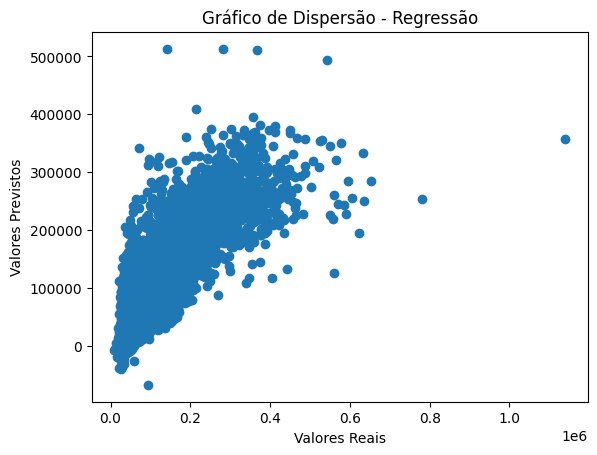

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

imprimir_metricas(y_val, y_pred)

Esse primeiro modelo errou uma média de 34 mil reais por veículo (pra mais ou pra menos) e 62% dos erros dos preços dos veículos estão abaixo desse erro.

Vamos calcular quais foram as colunas mais relevantes para esse modelo.

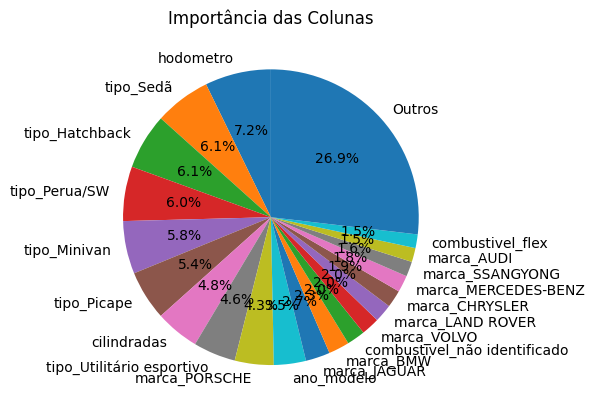

In [ ]:
principais_features(model.coef_ , X_train.columns , grafico=True)


Observamos que as colunas mais relevantes foram: `hodometro`, `tipo_Sedã`, `tipo_Hatchback`, `tipo_Perua/SW`, `tipo_Minivan`, `tipo_Picape`, `cilindradas`, `tipo_Utilitário esportivo`, `marca_PORSCHE`, `ano_modelo`, `marca_JAGUAR`, `marca_BMW`, `combustivel_não identificado`, `marca_VOLVO`, ` marca_LAND ROVER`, `marca_CHRYSLER`, ` marca_MERCEDES-BENZ`.

Vamos ver se o mesmo se repete para os outros modelos.

## Segundo Modelo: Random Forest

Em segundo lugar, usaremo o random forest, que é um modelo que junta trabaha com várias árvores de decisão de uma só vez.

Como nosso banco tem muitas variáveis categóricas, esse modelo pode nos trazer resultados interessantes.

Usaremos o CrossValidation para melhorar a capacidade de generalização do nosso modelo, dividindo os dados em vários (no nosso caso, 5) subconjuntos para realizar repetidas etapas de treinamento e avaliação.

Usaremos o RandomSearchCV pra buscar os melhores hiperparâmetros porque, com tantas colunas, o GridSearchCV leva muito tempo.

Melhores hiperparâmetros: {'n_estimators': 450, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 70}
MAE: 27446.95
MSE: 1712152278.85
RMSE: 41378.16
Veículos com menor erro que o MAE: 64.50%


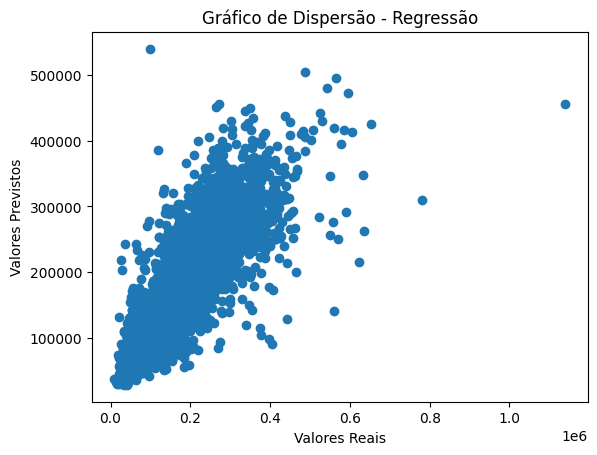

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import make_scorer

param_grid = {'n_estimators': [450],'max_depth': [70,80],
              'min_samples_split': [20,30],'min_samples_leaf': [2]}
model2 = RandomForestRegressor()

rand_search2 = RandomizedSearchCV(estimator=model2, param_distributions=param_grid, cv=5, scoring='neg_median_absolute_error', random_state=42,n_iter=4)
rand_search2.fit(X_train, y_train)
best_params2 = rand_search2.best_params_
print("Melhores hiperparâmetros:", best_params2)
y_pred = rand_search2.best_estimator_.predict(X_val)

#Melhores hiperparâmetros encontrados da primeira vez: {'n_estimators': 450, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 70}
imprimir_metricas(y_val, y_pred)

O RandomForest já diminuiu o erro médio absoluto para `R$27.446,95`. Menor que os `R$34.337,59` dados pelo modelo de regressão linear.

Por outro lado, o RandomForest demorou muito mais pra rodar no conjunto de dados, especialmente dado o grande número de colunas no nosso banco.

Futuramente tentaremos rodar os mesmos modelos com menos colunas a fim de verificar quais realmente ajudam na predição. Para isso, vejamos a importância de cada coluna.

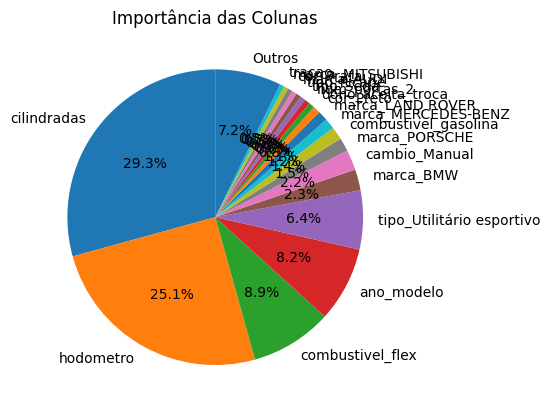

In [ ]:
importancias_ordenadas2 = principais_features(rand_search2.best_estimator_.feature_importances_ , X_train.columns , grafico=True)


Vamos tentar retreinar o modelo apenas com as features mais relevantes nesse primeiro treino. Isso pode melhorar a performance do modelo e o tempo de treinamento.

Melhores hiperparâmetros: {'n_estimators': 450, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 70}
MAE: 31235.51
MSE: 2097150992.19
RMSE: 45794.66
Veículos com menor erro que o MAE: 63.13%


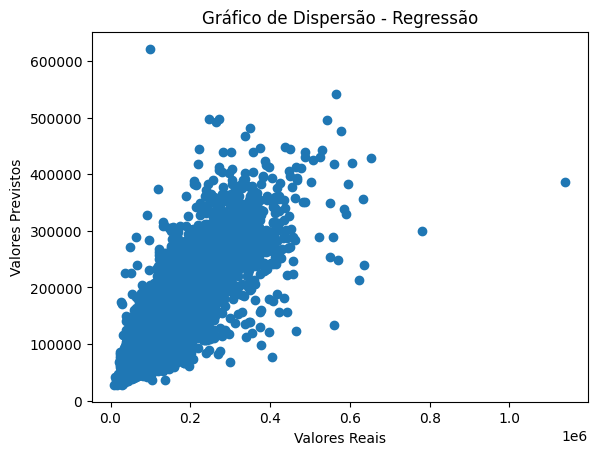

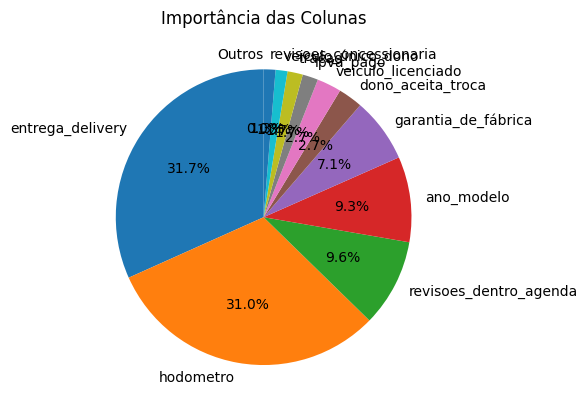

[0.3170777992964509,
 0.3098712902109374,
 0.09590555001418785,
 0.09340578232607785,
 0.07050192510830038,
 0.026769535420277806,
 0.026726925611533822,
 0.017074811530109733,
 0.016766554721171726,
 0.013017435996266839,
 0.012882389764685621]

In [ ]:
X_train_RF=X_train.copy()
X_val_RF=X_val.copy()
coeficientes_dict = dict(zip(X_train.columns, rand_search2.best_estimator_.feature_importances_))
coeficientes_ordenados = sorted(coeficientes_dict.items(), key=lambda x: abs(x[1]), reverse=True)
lista_cols_importancia0=[]
for coluna, coeficiente in coeficientes_ordenados:
    if coeficiente<0.01:
      lista_cols_importancia0.append(coluna)
X_train_RF.drop(list(lista_cols_importancia0),inplace=True, axis=1)
X_val_RF.drop(list(lista_cols_importancia0),inplace=True, axis=1)
#param_grid (usaremos a mesma grid de parâmetros)

model3 = RandomForestRegressor()

rand_search3 = RandomizedSearchCV(n_iter=4,estimator=model3, param_distributions=param_grid, cv=5, scoring='neg_median_absolute_error', random_state=42)
rand_search3.fit(X_train_RF, y_train)
best_params3 = rand_search3.best_params_

y_pred = rand_search3.best_estimator_.predict(X_val_RF)
print("Melhores hiperparâmetros:", best_params3)

imprimir_metricas(y_val, y_pred)
principais_features(rand_search3.best_estimator_.feature_importances_ , X_train_RF.columns , grafico=True)

O MAE aumentou um pouco. Mas, o tempo de treinamento diminuiu consideravelmente. Dependendo de quantas vezes precisaremos retreinar o modelo, essa opção pode ser mais interessante do que usar todas as colunas.

## Terceiro modelo: KNN

O KNN funciona calculando os "n" registros mais próximos (considerando cada registro como um vetor e uma função distância especificada) e colocando o valor predito como a média dos valores dos registros mais próximos.

O valor padrão de "n" é 3 e a distância padrão é a distância euclidiana.



Melhores hiperparâmetros: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'euclidean', 'leaf_size': 40}
MAE: 32371.95
MSE: 2377529033.94
RMSE: 48759.91
Veículos com menor erro que o MAE: 65.06%


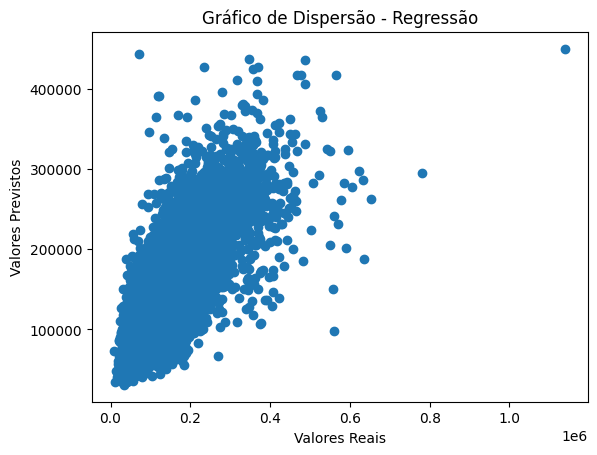

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors': [5,9],'weights': ['uniform','distance'],
              'metric': ['euclidean','manhattan'],'leaf_size': [20, 30, 40]}

model4 = KNeighborsRegressor()

rand_search4 = RandomizedSearchCV(estimator=model4, param_distributions=param_grid,
                                  cv=3, scoring='neg_mean_absolute_error', random_state=42, n_iter=5)
rand_search4.fit(X_train, y_train)
best_params4 = rand_search4.best_params_

y_pred = rand_search4.best_estimator_.predict(X_val)
print("Melhores hiperparâmetros:", best_params4)
imprimir_metricas(y_val, y_pred)


O KNN encontrou um MAE de 32 mil reais, que é maior do que os 27 mil reais do RandomForest, que ainda é nossa melhor opção.

O KNN não tem uma forma de avaliar a importância das features, já que não tem uma etapa de treinamento. Ele apenas calcula a média dos preços dos registros "mais parecidos" com o registro dado.

Mas, vamos tentar rodar uma versão do KNN usando apenas as colunas que encontramos como prioritárias no Random Forest.

Melhores hiperparâmetros: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'euclidean', 'leaf_size': 40}
MAE: 31807.91
MSE: 2162804588.03
RMSE: 46505.96
Veículos com menor erro que o MAE: 63.51%


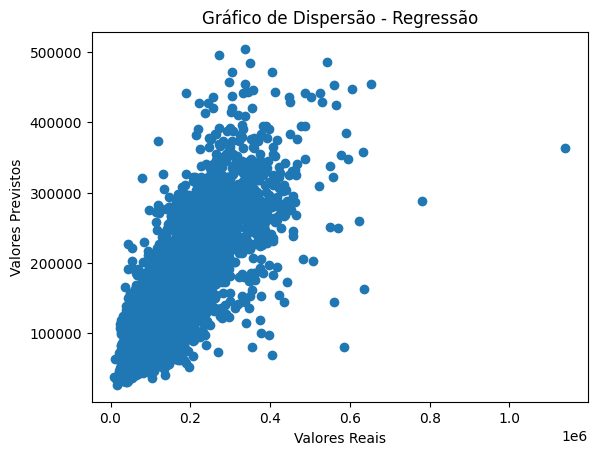

In [ ]:
# Com o mesmo param_grid
#X_train_RF
#X_val_RF

model5 = KNeighborsRegressor()

rand_search5 = RandomizedSearchCV(estimator=model5, param_distributions=param_grid,
                                  cv=3, scoring='neg_mean_absolute_error', random_state=42, n_iter=10)
rand_search5.fit(X_train_RF, y_train)
best_params5 = rand_search5.best_params_

y_pred = rand_search5.best_estimator_.predict(X_val_RF)
print("Melhores hiperparâmetros:", best_params5)

imprimir_metricas(y_val, y_pred)


Com isso, diminuimos o MAE para `R$31.807`. Mas, ainda não é melhor que nosso primeiro ou segundo RandomForest.

## Quarto modelo: Rede neural com Keras

Treinaremos uma rede neural simples para o nosso problema.

278/278 [==============================] - 1s 2ms/step - loss: 29267.4551
MAE: 29267.46
MSE: 1985093306.06
RMSE: 44554.39


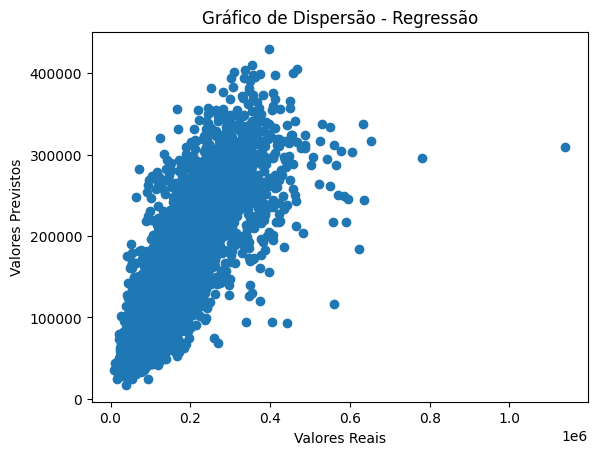

In [ ]:
# importando layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop

# Criando arquitetura da rede
RedeN = Sequential()
RedeN.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
RedeN.add(Dense(20, activation='relu'))
RedeN.add(Dense(14, activation='relu'))
RedeN.add(Dense(7, activation='relu'))
RedeN.add(Dense(1, activation='linear'))

# compilando o modelo
#RedeN.compile(optimizer='adam', loss='mean_absolute_error')
#optimizer = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-8) : 29mil com 20,14,7,1
#RedeN.compile(optimizer=optimizer, loss='mean_absolute_error')
RedeN.compile(optimizer=RMSprop(), loss='mean_absolute_error') # MAE: 28mil com 20,14,7,1
callback = EarlyStopping(monitor='loss', patience=2, verbose=1)

# treinando o modelo
history = RedeN.fit(X_train, y_train, epochs=100, callbacks=[callback], verbose=False)

# fazendo previsões e calculando classification_report
y_pred = RedeN.predict(X_val)
loss = RedeN.evaluate(X_val, y_val)
imprimir_metricas(y_val, y_pred,False)

# Escolha do modelo e cálculo dos preços no `df_test`

Depois de todas essas tentativas, acabamos por optar pelo modelo de Regressão Linear com todas as colunas com os hiperparâmetros `{'n_estimators': 450, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 70}` que encontramos com o Randomized Search CV.

Vamos aplicá-lo ao df_test e armazenar os resultados num arquivo `csv`.

In [ ]:
#rand_search2

#y_test = rand_search2.best_estimator_.predict(X_test)
df_test_OHE
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Dados_tratados_test = pd.DataFrame(scaler.fit_transform(df_test_OHE), columns=df_test_OHE.columns)

#print(Dados_tratados_test)
y_test = rand_search2.best_estimator_.predict(Dados_tratados_test)



In [ ]:
df_test_final['preco'] = y_test


In [ ]:
#print(df_test_final)
df_test_final.to_csv('lighthouse_cars_test_preco.csv', index=False)